In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import optuna

from sklearn.pipeline import make_pipeline

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, KFold,ShuffleSplit,GridSearchCV,cross_val_score,StratifiedKFold


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Ваш код здесь
import time

In [4]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [5]:
file_path = '/content/drive/My Drive/RussiaRealEstate_with_new_col.csv'

In [6]:
%%time
data = pd.read_csv(file_path, sep=';')

CPU times: user 11.2 s, sys: 1.73 s, total: 12.9 s
Wall time: 16.6 s


In [7]:
data

,Unnamed: 0.1,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,...,area,kitchen_area,object_type,Rate,year,"GDP, rub.","mean inflation, %","unemployment rate, %",Total fertility rate,"average monthly nominal wage, thousand rubles."
0,0,0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,...,82.6,10.8,1,7.75,2018,103861.7,2.88,4.85,-1.58,43724
1,1,1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,...,69.1,12.0,1,7.75,2018,103861.7,2.88,4.85,-1.58,43724
2,2,2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,...,66.0,10.0,1,7.75,2018,103861.7,2.88,4.85,-1.58,43724
3,3,3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,...,38.0,5.0,11,7.75,2018,103861.7,2.88,4.85,-1.58,43724
4,4,4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,...,60.0,10.0,1,7.75,2018,103861.7,2.88,4.85,-1.58,43724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477001,5477001,5477001,19739760,2021-05-01,20:13:58,55.804736,37.750898,3,1,8,...,93.2,13.8,11,4.50,2021,134727.5,6.68,4.72,-1.50,57244
5477002,5477002,5477002,12503160,2021-05-01,20:14:01,55.841415,37.489624,3,2,17,...,45.9,6.6,11,4.50,2021,134727.5,6.68,4.72,-1.50,57244
5477003,5477003,5477003,8800000,2021-05-01,20:14:04,56.283909,44.075408,2871,2,4,...,86.5,11.8,1,4.50,2021,134727.5,6.68,4.72,-1.50,57244
5477004,5477004,5477004,11831910,2021-05-01,20:14:12,55.804736,37.750898,3,1,8,...,52.1,18.9,11,4.50,2021,134727.5,6.68,4.72,-1.50,57244


In [8]:
data.shape

(5477006, 22)

Keeping only the new buildings

In [9]:
data = data[data['object_type'] == 11]

In [10]:
data.drop('object_type', axis=1, inplace=True)

<ipython-input-10-02be41abea89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('object_type', axis=1, inplace=True)


Delete unnecessary variables

In [11]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('Unnamed: 0.1', axis=1, inplace=True)

<ipython-input-11-f32dfb147605>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Unnamed: 0', axis=1, inplace=True)
<ipython-input-11-f32dfb147605>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Unnamed: 0.1', axis=1, inplace=True)


Let's rename the columns for convenience

In [ ]:
data = data.rename(columns={'Rate': 'rate', 'GDP, rub.': 'GDP', 'Total fertility rate.': 'total fertility rate', 'average monthly nominal wage, thousand rubles. ': 'average nominal wage', 'mean inflation, %': 'inflation', 'unemployment rate, %': 'unemployment rate'})

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613197 entries, 3 to 5477005
Data columns (total 19 columns):
 #   Column                                           Non-Null Count    Dtype  
---  ------                                           --------------    -----  
 0   price                                            1613197 non-null  int64  
 1   date                                             1613197 non-null  object 
 2   time                                             1613197 non-null  object 
 3   geo_lat                                          1613197 non-null  float64
 4   geo_lon                                          1613197 non-null  float64
 5   region                                           1613197 non-null  int64  
 6   building_type                                    1613197 non-null  int64  
 7   level                                            1613197 non-null  int64  
 8   levels                                           1613197 non-null  int64  
 9   rooms  

In [15]:
data.shape

(1613197, 19)

In [16]:
data.isna().sum()

,0
price,0
date,0
time,0
geo_lat,0
geo_lon,0
region,0
building_type,0
level,0
levels,0
rooms,0


In [17]:
data.duplicated().sum()

np.int64(1308)

For ease of analysis with the region variable, the data were converted to a string description based on the region's federal number.

In [18]:
region_name = {
    '2661': 'Saint Petersburg',
    '3446': 'Leningrad region',
    '3': 'Moscow',
    '81': 'Moscow region',
    '2843': 'Krasnodar Region',
    '2871': 'Nizhny Novgorod region',
    '3230': 'Rostov region',
    '3106': 'Samara region',
    '2922': 'Republic of Tatarstan',
    '2900': 'Stavropol Territory',
    '2722': 'Republic of Bashkortostan',
    '6171': 'Sverdlovsk region',
    '4417': 'Komi Republic',
    '5282': 'Chelyabinsk region',
    '5368': 'Irkutsk region',
    '5520': 'Perm region',
    '6817': 'Altai region',
    '9579': 'Republic of Buryatia',
    '2604': 'Yaroslavl region',
    '1010': 'Udmurt Republic',
    '7793': 'Pskov region',
    '13919': 'Republic of North Ossetia-Alania',
    '2860': 'Kemerovo region',
    '3019': 'Chuvash Republic',
    '4982': 'Republic of Mari El',
    '9648': 'Kabardino-Balkarian Republic',
    '5241': 'Republic of Mordovia',
    '3870': 'Krasnoyarsk region',
    '3991': 'Tyumen Region',
    '2359': 'Republic of Khakassia',
    '9654': 'Novosibirsk region',
    '2072': 'Voronezh region',
    '8090': 'Republic of Karelia',
    '4007': 'Republic of Dagestan',
    '11171': 'Republic of Sakha (Yakutia)',
    '10160': 'Transbaikal Territory',
    '7873, 6937': 'Republic of Crimea',
    '2594': 'Kirov region',
    '8509': 'Republic of Kalmykia',
    '11416': 'Republic of Adygea',
    '11991': 'Karachay-Cherkess Republic',
    '5178': 'Republic of Tyva',
    '13913': 'Republic of Ingushetia',
    '6309': 'Altai Republic',
    '5952': 'Belgorod region',
    '6543': 'Arkhangelsk region',
    '2880': 'Tver region',
    '5993': 'Penza region',
    '2484': 'Khanty-Mansiysk Autonomous District',
    '4240': 'Lipetsk region',
    '5789': 'Vladimir region',
    '14880': 'Yamal-Nenets Autonomous District',
    '1491': 'Ryazan region',
    '2885': 'Chechen Republic',
    '5794': 'Smolensk region',
    '2528': 'Saratov region',
    '4374': 'Vologda Oblast',
    '4695': 'Volgograd Region',
    '2328': 'Kaluga region',
    '5143': 'Tula region',
    '2806': 'Tambov region',
    '14368': 'Murmansk region',
    '5736': 'Novgorod region',
    '7121': 'Kursk region',
    '4086': 'Khabarovsk region',
    '821': 'Bryansk region',
    '10582': 'Astrakhan region',
    '7896': 'Kaliningrad region',
    '8640': 'Omsk region',
    '5703': 'Kurgan region',
    '10201': 'Tomsk region',
    '4249': 'Ulyanovsk region',
    '3153': 'Orenburg region',
    '4189': 'Kostroma region',
    '2814': 'Orel region',
    '13098': 'Kamchatka region',
    '8894': 'Ivanovo region',
    '7929': 'Amur Region',
    '16705': 'Magadan region',
    '69': 'Jewish Autonomous Region',
    '4963': 'Primorsky Krai',
    '1901': 'Sakhalin Oblast',
    '61888': 'Nenets Autonomous District'
}

data["region"] = data["region"].astype(str)
data['region_name'] = data['region'].map(region_name)

<ipython-input-18-1099d6a97c03>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["region"] = data["region"].astype(str)
<ipython-input-18-1099d6a97c03>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['region_name'] = data['region'].map(region_name)


In [26]:
data.drop('geo_lat', axis = 1, inplace=True)
data.drop('geo_lon', axis = 1, inplace=True)

<ipython-input-26-09f120618866>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('geo_lat', axis = 1, inplace=True)
<ipython-input-26-09f120618866>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('geo_lon', axis = 1, inplace=True)


##EDA

Text(0, 0.5, ' ')

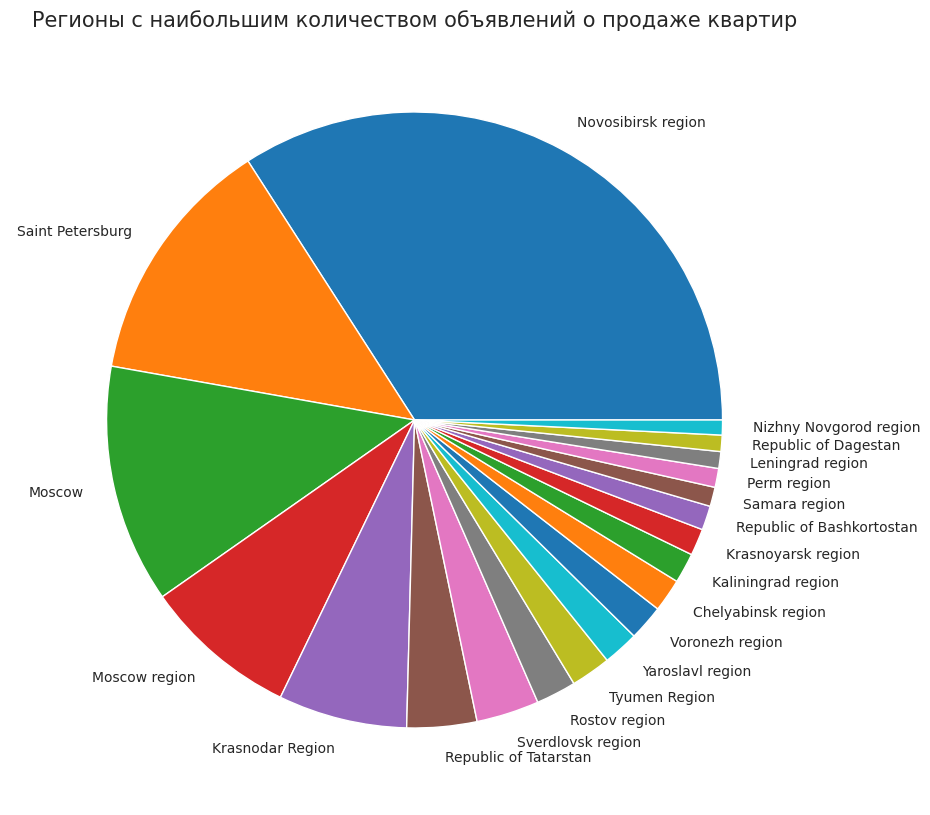

In [27]:
data['region_name'].value_counts().head(20).plot(kind='pie',stacked=True,figsize=(10,10))
plt.title("Regions with the largest number of advertisements for apartments for sale",fontsize=15)
plt.ylabel(' ')

In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [29]:
data['price'].describe()

,price
count,1613197.00
mean,4638323.37
std,32436026.99
min,-2114150296.00
25%,1850000.00
50%,3100000.00
75%,5400000.00
max,2147483647.00


In [30]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1613197.00,4638323.37,32436026.99,-2114150296.00,1850000.00,3100000.00,5400000.00,2147483647.00
building_type,1613197.00,1.67,0.92,0.00,1.00,2.00,2.00,5.00
level,1613197.00,8.07,5.79,1.00,3.00,7.00,11.00,39.00
levels,1613197.00,15.24,6.65,1.00,10.00,15.00,19.00,39.00
rooms,1613197.00,1.49,1.12,-2.00,1.00,1.00,2.00,9.00
area,1613197.00,54.31,30.09,0.48,39.00,48.95,63.85,7625.00
kitchen_area,1613197.00,12.12,6.67,0.01,8.90,11.57,14.40,3000.00
Rate,1613197.00,6.50,1.23,4.25,6.00,7.25,7.50,7.75
year,1613197.00,2019.34,0.87,2018.00,2019.00,2019.00,2020.00,2021.00
"GDP, rub.",1613197.00,110551.85,8292.11,103861.70,107658.10,109608.30,109608.30,134727.50


Abnormal value

In [31]:
data[data['area'] == 7625]

,price,date,time,region,building_type,level,levels,rooms,area,kitchen_area,Rate,year,"GDP, rub.","mean inflation, %","unemployment rate, %",Total fertility rate,"average monthly nominal wage, thousand rubles.",region_name
3608366,3360000,2020-04-16,11:33:12,2843,3,5,19,2,7625.00,22.20,6.25,2020,107658.10,3.38,5.59,-1.50,51344,Krasnodar Region


In [32]:
data[data['kitchen_area'] == 3000]

,price,date,time,region,building_type,level,levels,rooms,area,kitchen_area,Rate,year,"GDP, rub.","mean inflation, %","unemployment rate, %",Total fertility rate,"average monthly nominal wage, thousand rubles.",region_name
1756576,500,2019-05-07,14:47:40,81,5,24,1,5,2000.00,3000.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Moscow region


In [33]:
data.describe(include='object').T

,count,unique,top,freq
date,1613197,995,2020-03-27,15503
time,1613197,86266,06:32:22,107
region,1613197,82,9654,513379
region_name,1610958,80,Novosibirsk region,513379


You can see that there are gaps in the region_name column, so there are two regions missing

In [34]:
for col in data.columns:
  none_count = data[col].isnull().sum()
  print(f"Column '{col}': {none_count} None")

Column 'price': 0 None
Column 'date': 0 None
Column 'time': 0 None
Column 'region': 0 None
Column 'building_type': 0 None
Column 'level': 0 None
Column 'levels': 0 None
Column 'rooms': 0 None
Column 'area': 0 None
Column 'kitchen_area': 0 None
Column 'Rate': 0 None
Column 'year': 0 None
Column 'GDP, rub.': 0 None
Column 'mean inflation, %': 0 None
Column 'unemployment rate, %': 0 None
Column 'Total fertility rate': 0 None
Column 'average monthly nominal wage, thousand rubles. ': 0 None
Column 'region_name': 2239 None


In [35]:
data[data['region_name'].isnull()]['region'].unique()

array(['7873', '6937'], dtype=object)

In [36]:
numeric_columns = list(data.select_dtypes(exclude=['object'],).columns)

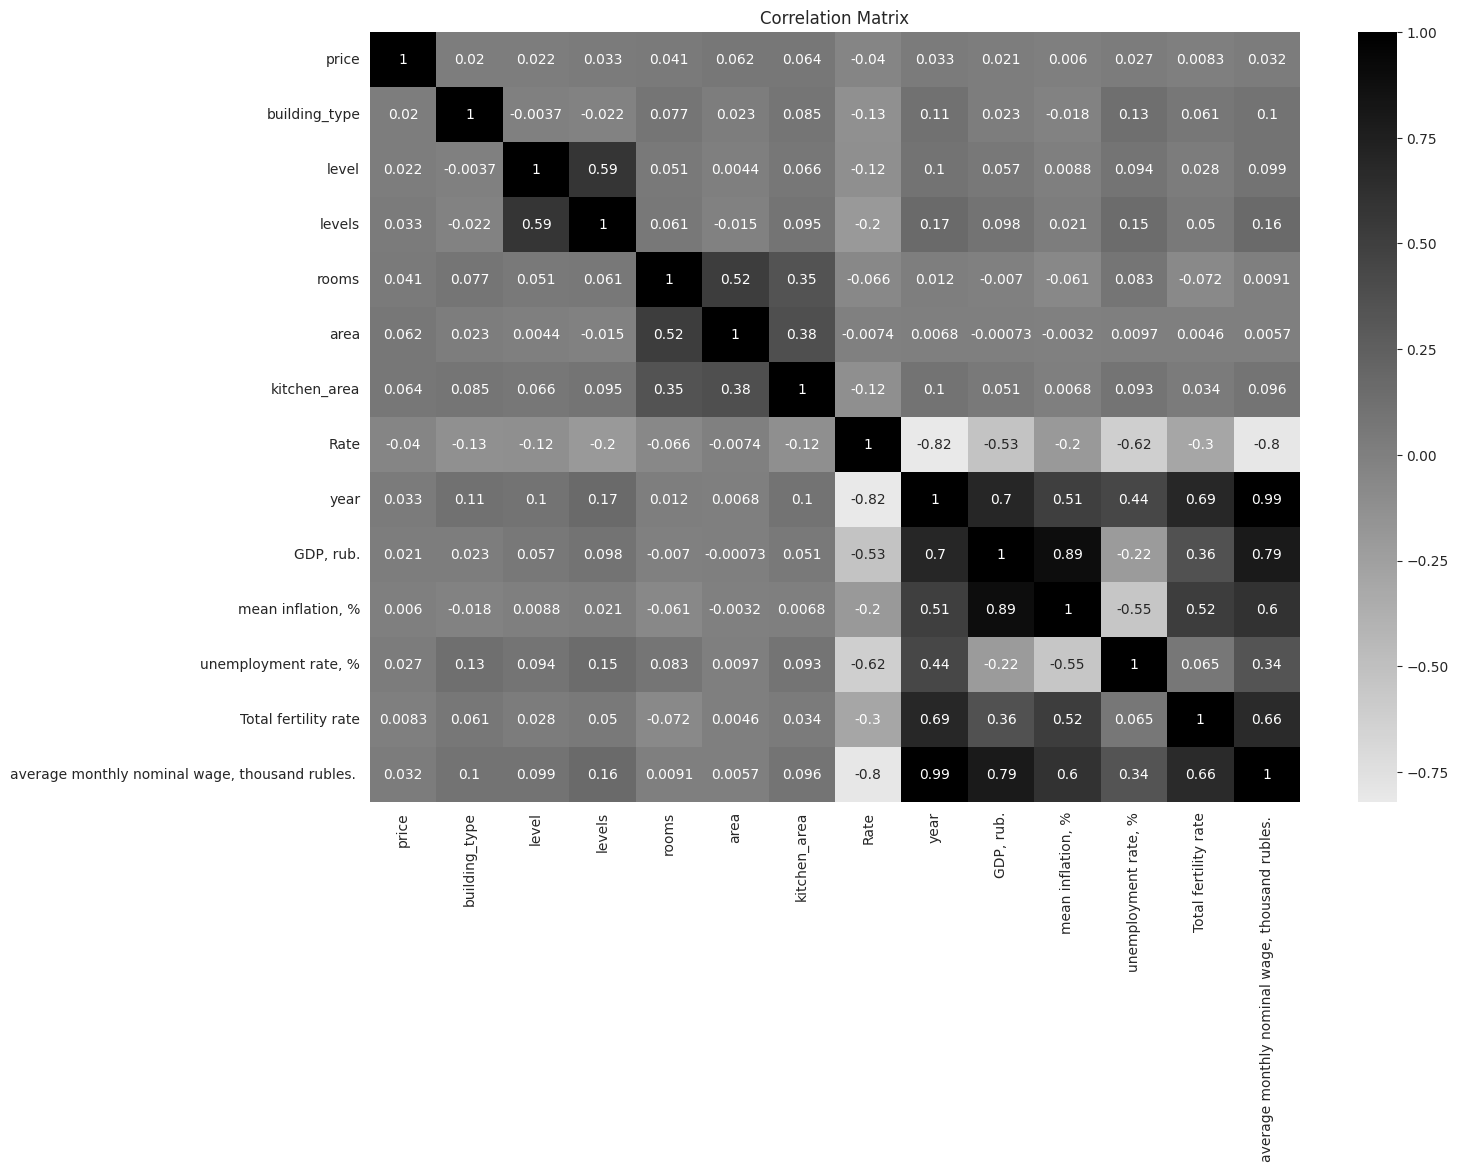

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(data[numeric_columns].corr(), center=0, cmap='binary', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [38]:
data['region_name'].value_counts()

,count
region_name,
Novosibirsk region,513379
Saint Petersburg,197254
Moscow,188672
Moscow region,121923
Krasnodar Region,101823
...,...
Kamchatka region,9
Jewish Autonomous Region,7
Murmansk region,1


In [39]:
mean_price = data.groupby('region_name', as_index=False).agg(avg_price = ("price", "mean")).round(2)
mean_price

,region_name,avg_price
0,Altai Republic,2317665.70
1,Altai region,2476317.90
2,Amur Region,4283253.66
3,Arkhangelsk region,4074832.82
4,Astrakhan region,3704687.44
...,...,...
75,Volgograd Region,2852911.77
76,Vologda Oblast,2559963.03
77,Voronezh region,3026637.32
78,Yamal-Nenets Autonomous District,2959090.91


In [40]:
mean_price.sort_values(by = 'avg_price', ascending=False)

,region_name,avg_price
30,Moscow,12141034.08
59,Saint Petersburg,7996899.86
19,Khabarovsk region,5298035.69
31,Moscow region,5244575.31
16,Kamchatka region,4361111.11
...,...,...
51,Republic of Mari El,2044345.69
26,Kurgan region,2000206.17
43,Republic of Adygea,1781774.45
41,Primorsky Krai,1650000.00


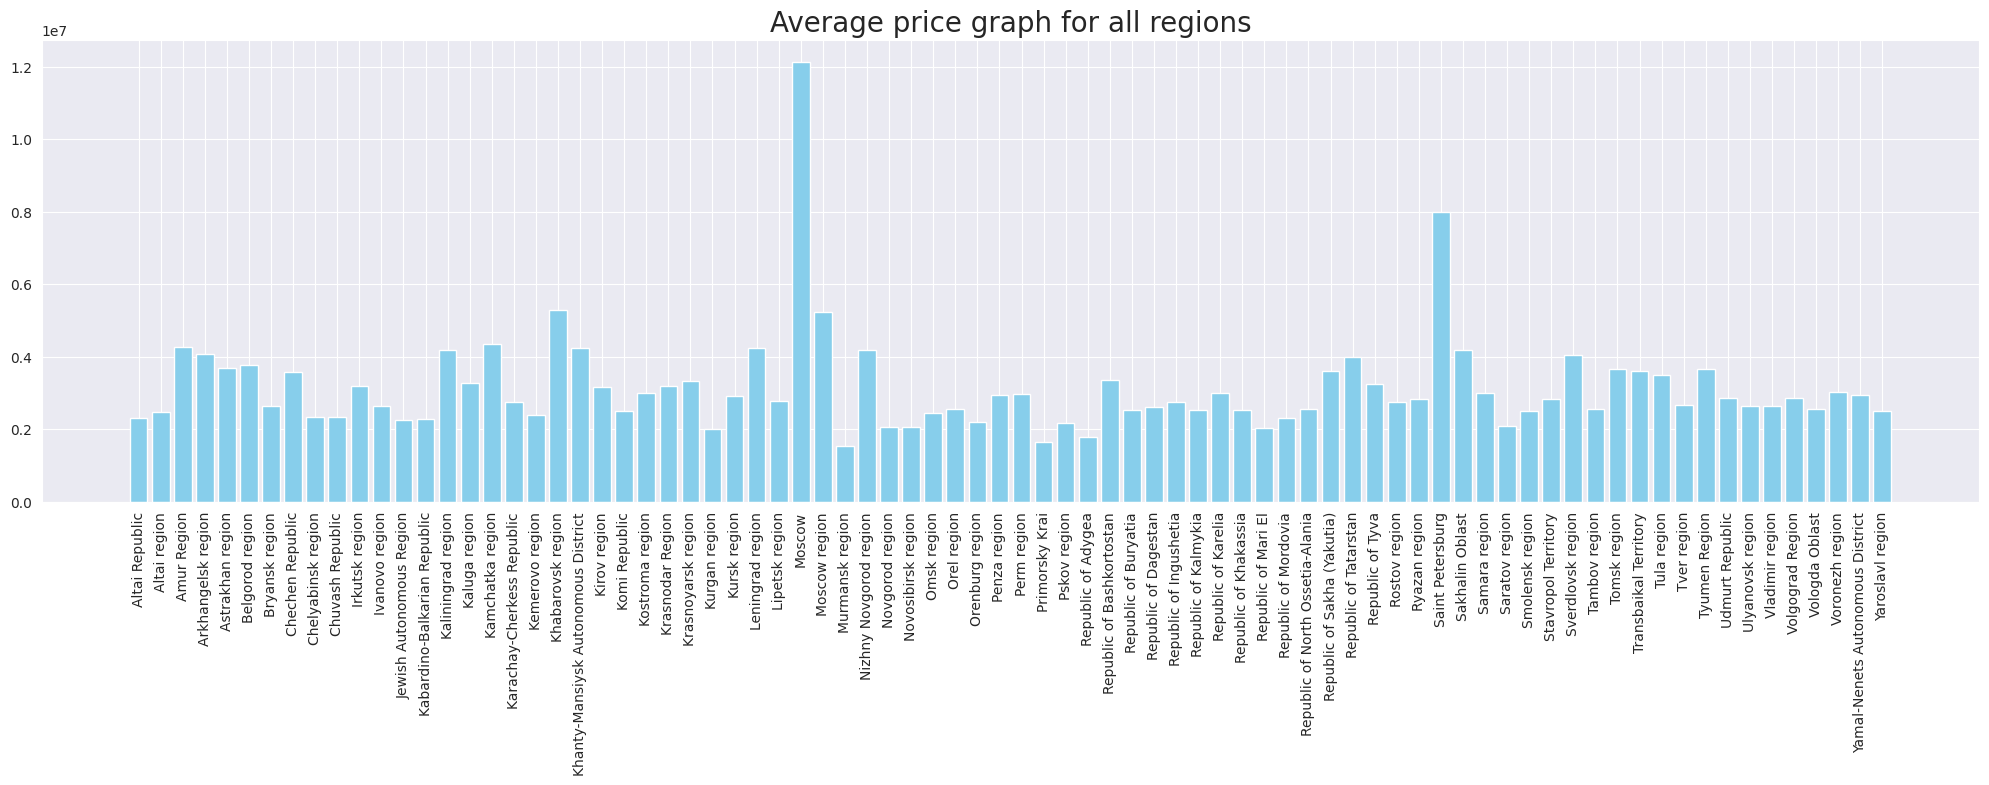

In [41]:
plt.figure(figsize=(25, 6))
plt.bar(x=mean_price['region_name'],height=mean_price['avg_price'], color='skyblue')
plt.title('Average price graph for all regions', fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [42]:
max_price = data.groupby('region_name', as_index=False).agg(max_price = ("price", "max")).round(1)

In [43]:
max_price['max_price'] = max_price['max_price'].astype(int)

In [44]:
max_price.sort_values(by = 'max_price', ascending=False).head(20)

,region_name,max_price
71,Tyumen Region,2147483647
24,Krasnodar Region,2089477704
35,Novosibirsk region,2083290000
14,Kaliningrad region,1285032704
59,Saint Petersburg,905032704
30,Moscow,770144768
44,Republic of Bashkortostan,554874390
46,Republic of Dagestan,265000000
31,Moscow region,234025676
47,Republic of Ingushetia,170000000


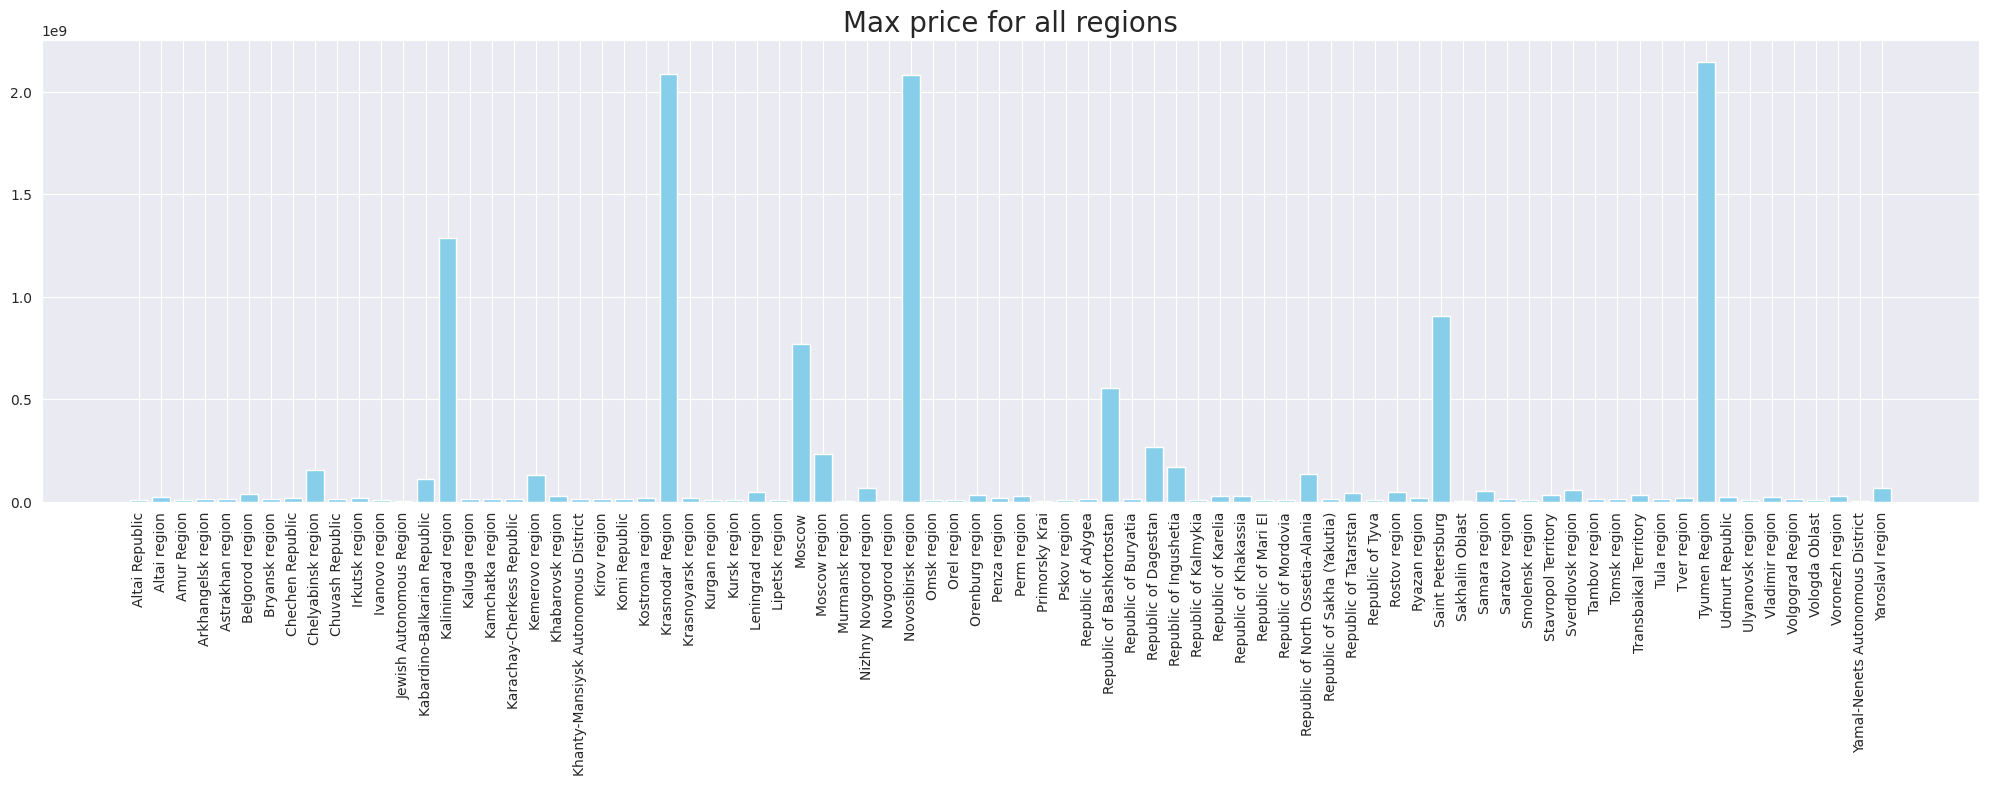

In [45]:
plt.figure(figsize=(25, 6))
plt.bar(x=max_price['region_name'],height=max_price['max_price'], color='skyblue')
plt.title('Max price for all regions', fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [46]:
cheapest = data.sort_values(by = 'price', ascending=True)
cheapest[['region_name', 'price']].head(10)

,region_name,price
2111957,Novosibirsk region,-2114150296
1990956,Novosibirsk region,-2114150296
1241775,Novosibirsk region,-2114150296
1999879,Novosibirsk region,-2114150296
2007413,Novosibirsk region,-2114150296
1919009,Novosibirsk region,-2114150296
1815314,Novosibirsk region,-2114150296
445500,Novosibirsk region,-2114150296
1209803,Novosibirsk region,-2114150296
1690884,Novosibirsk region,-2114150296


It's a strange object, let's remember

In [47]:
data[data['price'] == -2114150296]

,price,date,time,region,building_type,level,levels,rooms,area,kitchen_area,Rate,year,"GDP, rub.","mean inflation, %","unemployment rate, %",Total fertility rate,"average monthly nominal wage, thousand rubles.",region_name
445500,-2114150296,2018-11-09,01:47:08,9654,1,2,10,3,87.00,13.00,7.25,2018,103861.70,2.88,4.85,-1.58,43724,Novosibirsk region
1100970,-2114150296,2019-02-08,02:12:34,9654,1,8,10,3,87.39,13.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
1108531,-2114150296,2019-02-09,02:28:45,9654,1,8,10,3,87.39,13.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
1114226,-2114150296,2019-02-10,04:54:26,9654,1,8,10,3,87.39,13.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
1119183,-2114150296,2019-02-11,03:04:59,9654,1,8,10,3,87.39,13.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077694,-2114150296,2019-06-27,06:30:24,9654,1,8,10,3,87.39,13.00,7.75,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
2085698,-2114150296,2019-06-28,01:39:47,9654,1,8,10,3,87.39,13.00,7.75,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
2095267,-2114150296,2019-06-29,07:13:36,9654,1,8,10,3,87.39,13.00,7.75,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region
2099878,-2114150296,2019-06-30,06:14:16,9654,1,8,10,3,87.39,13.00,7.75,2019,109608.30,4.61,4.50,-1.50,47867,Novosibirsk region


In [48]:
data[data['price'] == 0]

,price,date,time,region,building_type,level,levels,rooms,area,kitchen_area,Rate,year,"GDP, rub.","mean inflation, %","unemployment rate, %",Total fertility rate,"average monthly nominal wage, thousand rubles.",region_name
1193624,0,2019-02-20,15:31:35,3230,3,1,3,2,57.00,9.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Rostov region
1766269,0,2019-05-09,23:52:32,81,3,2,3,-1,109.50,20.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Moscow region
1905050,0,2019-05-31,15:29:28,81,2,12,17,-1,46.60,12.00,7.50,2019,109608.30,4.61,4.50,-1.50,47867,Moscow region
2172626,0,2019-07-09,12:15:05,4007,2,10,17,1,42.00,12.30,7.75,2019,109608.30,4.61,4.50,-1.50,47867,Republic of Dagestan


In [49]:
data["price"].skew()

np.float64(-23.63950372188971)

(0.0, 30000000.0)

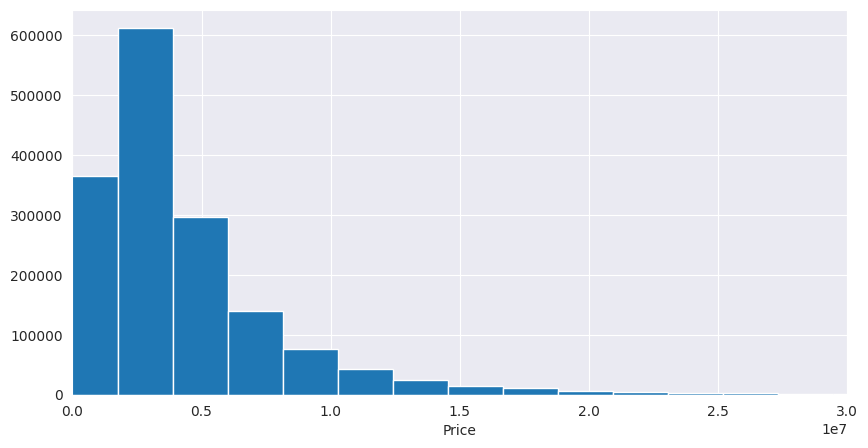

In [50]:
plt.figure(figsize=(10,5))
plt.hist(data["price"].astype(int), ec='black', bins=2000)
plt.xlabel('Price')
plt.xlim(0, 30000000)

{'whiskers': [<matplotlib.lines.Line2D at 0x7cefaf69cc10>,
 'caps': [<matplotlib.lines.Line2D at 0x7cef9c591590>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7cef9c6e91d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7cef9c592990>],
 'fliers': [<matplotlib.lines.Line2D at 0x7cef9c593250>],
 'means': []}

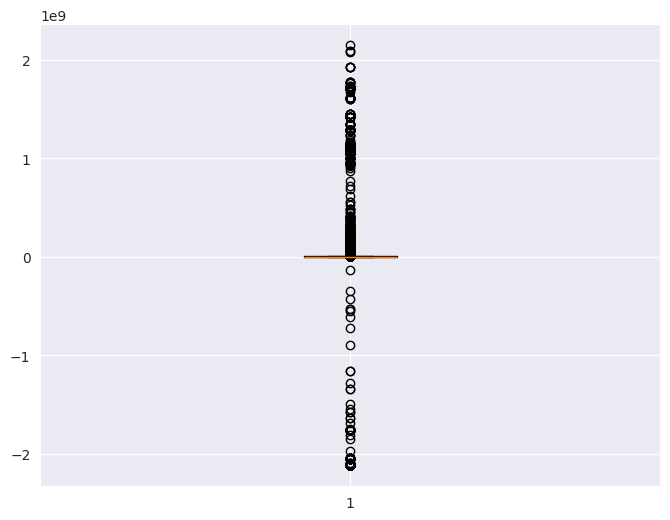

In [51]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['price'], vert=True, patch_artist=True, showfliers=True)

Outliers

Counting the number of emissions in variables

In [52]:
def count_outliers(df, iqr_multiplier=1.5):
    outlier_counts = {}

    for col in df.select_dtypes(include=np.number):
        Q1 = df[col].quantile(0.10)
        Q3 = df[col].quantile(0.90)
        IQR = Q3 - Q1

        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_counts[col] = len(outliers)

    outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Number of emissions'])
    outlier_df.index.name = 'Variable'
    return outlier_df.sort_values(by='Number of emissions', ascending=False)

In [53]:
outlier_counts_df = count_outliers(data)
print(outlier_counts_df)

                                                 Количество выбросов
Переменная                                                          
GDP, rub.                                                     160966
price                                                          25544
kitchen_area                                                    5045
area                                                            4245
rooms                                                            152
level                                                             38
levels                                                             0
building_type                                                      0
Rate                                                               0
year                                                               0
mean inflation, %                                                  0
unemployment rate, %                                               0
Total fertility rate              

In [54]:
sum(outlier_counts_df['Number of emissions'])

195990

In [55]:
sum(outlier_counts_df['Number of emissions']) / len(data) *100

12.149167150695172

In [56]:
data['rooms'].abs().value_counts()

,count
rooms,
1,830724
2,487169
3,273474
4,19199
5,2217
6,262
7,91
9,41
8,20


Text(0, 0.5, 'Price')

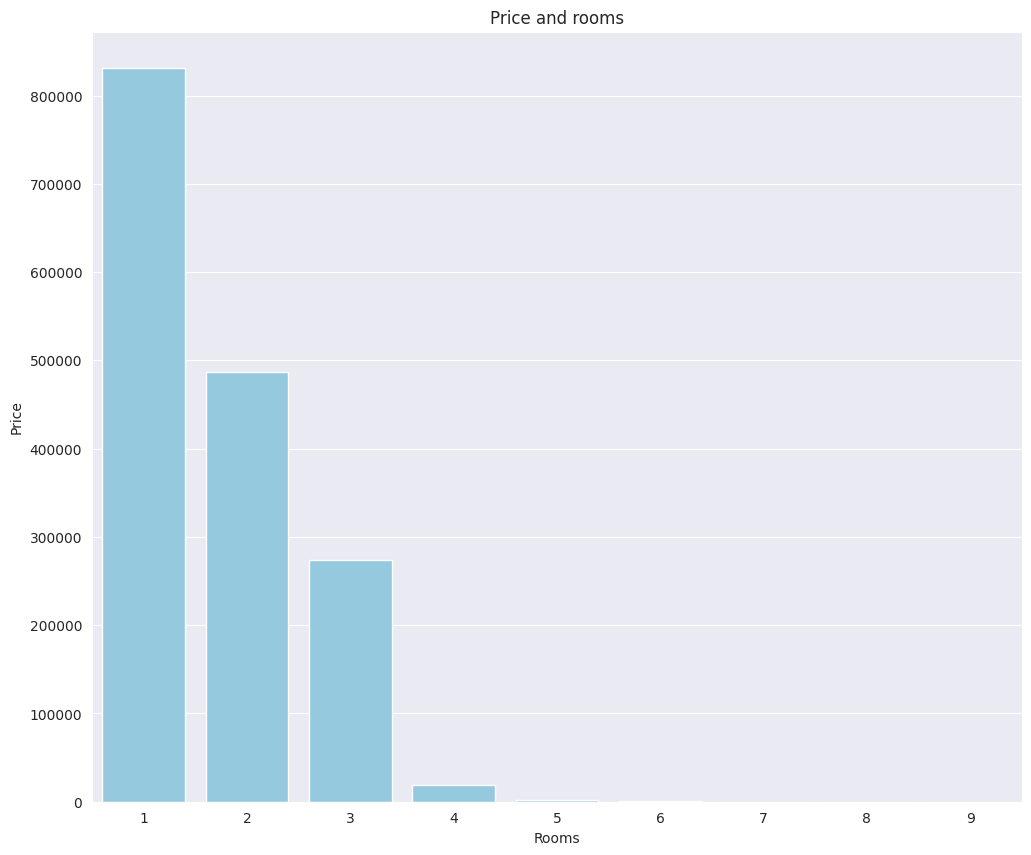

In [57]:
plt.figure(figsize=(12, 10))
sns.barplot(x=data['rooms'].abs().value_counts().index, y=data['rooms'].abs().value_counts().values, color='skyblue')
plt.title('Price and rooms')
plt.xlabel('Rooms')
plt.ylabel('Price')

In [58]:
data['rooms'].abs().value_counts()

,count
rooms,
1,830724
2,487169
3,273474
4,19199
5,2217
6,262
7,91
9,41
8,20


<ipython-input-59-19a9c21ddfb5>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='region_name', y='rooms', data=data, ci=None, color='skyblue')  # ci=None отключает отображение доверительных интервалов


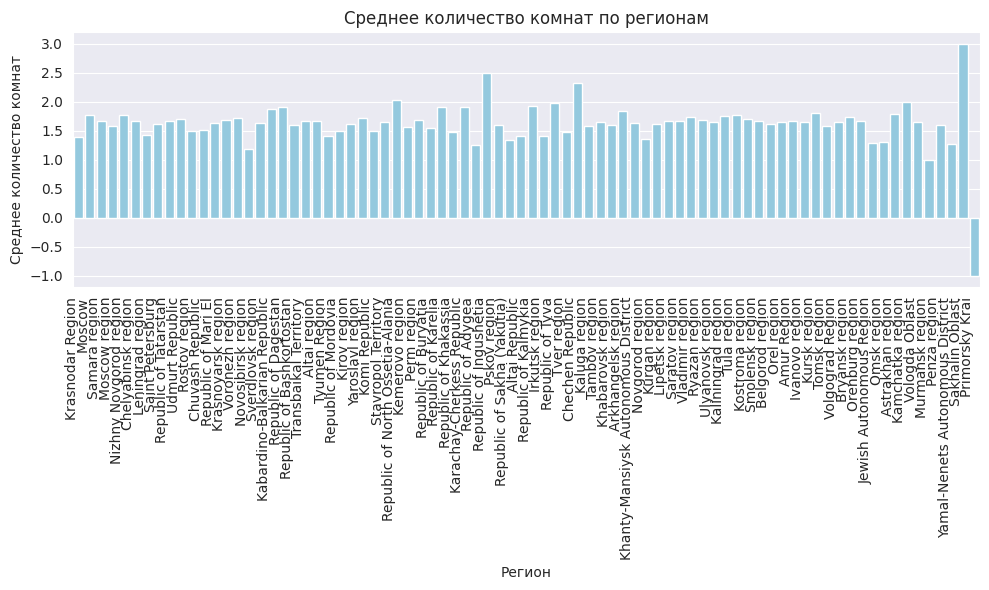

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region_name', y='rooms', data=data, ci=None, color='skyblue')
plt.title('Average number of rooms by region')
plt.xlabel('Region')
plt.ylabel('Average number of rooms')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## Dealing with all substandard objects

In [60]:
data.shape

(1613197, 18)

•	Removed items with “kitchen_area” greater than “area” and “level” greater than “levels” in number 577

In [61]:
index_to_drop = data[data['level'] > data['levels']].index
data.drop(index_to_drop, inplace=True)

<ipython-input-61-1449b4c9d11b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(index_to_drop, inplace=True)


In [62]:
index_to_drop = data[data['kitchen_area'] > data['area']].index
data.drop(index_to_drop, inplace=True)

<ipython-input-62-cf8b2816e638>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(index_to_drop, inplace=True)


In [63]:
data.shape

(1612620, 18)

In [64]:
data["price"] = data["price"].astype(float)

<ipython-input-64-7b37468a5cfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["price"] = data["price"].astype(float)


Изменим знак цены, комнат

In [65]:
data['price'] = data['price'].abs()
data['rooms'] = data['rooms'].abs()

<ipython-input-65-ab186c907e01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['price'].abs()
<ipython-input-65-ab186c907e01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rooms'] = data['rooms'].abs()


Удаляем нулевые значения в столбце 'price'

In [66]:
data[data["price"]  == 0].index

Index([1193624, 1766269, 1905050, 2172626], dtype='int64')

In [67]:
index_to_drop = data[data["price"]  == 0].index
data.drop(index_to_drop, inplace=True)

<ipython-input-67-6e647af97594>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(index_to_drop, inplace=True)


Удаляем данные с неизвестными регионами '6937', '7873'

In [68]:
len(data[(data['region'] == '6937') | (data['region'] == '7873')])

2238

In [69]:
data = data[~data['region'].isin(['6937', '7873'])]

Работа над выбросами

In [70]:
data.shape

(1610378, 18)

Удаляем, так как замена на медиану или среднее даёт плохое качество. Выбор наилучшего качества пал на границы 10 и 90

In [71]:
def remove_outliers_iqr(df, iqr_multiplier=1.5):
    df_filtered = df.copy()

    for col in df.select_dtypes(include=np.number):
        Q1 = df_filtered[col].quantile(0.10)
        Q3 = df_filtered[col].quantile(0.90)
        IQR = Q3 - Q1

        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)] # Фильтруем df_filtered

    return df_filtered

data = remove_outliers_iqr(data)

A single row can contain multiple outliers: As I mentioned earlier, a single row can contain values that count as outliers in several different columns. The count_outliers function counts each of these cases as a separate outlier, while the remove_outliers_iqr function removes a row only once, regardless of how many outliers it contains.

Transform object "date" и "time"

In [74]:
data['datetime'] = pd.to_datetime(data['date'] +  ' ' +  data['time'])

<ipython-input-74-58c804976706>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['date'] +  ' ' +  data['time'])


In [75]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second

<ipython-input-75-d6dcee9ff411>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['datetime'].dt.year
<ipython-input-75-d6dcee9ff411>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['datetime'].dt.month
<ipython-input-75-d6dcee9ff411>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [76]:
data.drop(['date', 'time',  'datetime', 'region_name'], axis=1, inplace = True)

<ipython-input-76-2cf417003ba7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['date', 'time',  'datetime', 'region_name'], axis=1, inplace = True)


Add columnn which tells about covid period

In [77]:
def is_covid_year(year):
    if year >= 2020:
        return 1
    else:
        return 0

data['covid'] = data['year'].apply(is_covid_year)

<ipython-input-77-536b4a97a312>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['covid'] = data['year'].apply(is_covid_year)


In [78]:
data.to_csv('clean_table_with_external_columns.csv', index=False)

Load ready data

In [79]:
data_with_external_col = pd.read_csv('clean_table_with_external_columns.csv', sep=',')

In [80]:
initial_data = data_with_external_col.drop(['Rate', 'GDP, rub.', 'mean inflation, %', 'unemployment rate, %', 'Total fertility rate', 'average monthly nominal wage, thousand rubles. ', 'covid'], axis = 1)

In [ ]:
initial_data.to_csv('initial_data.csv', index=False)

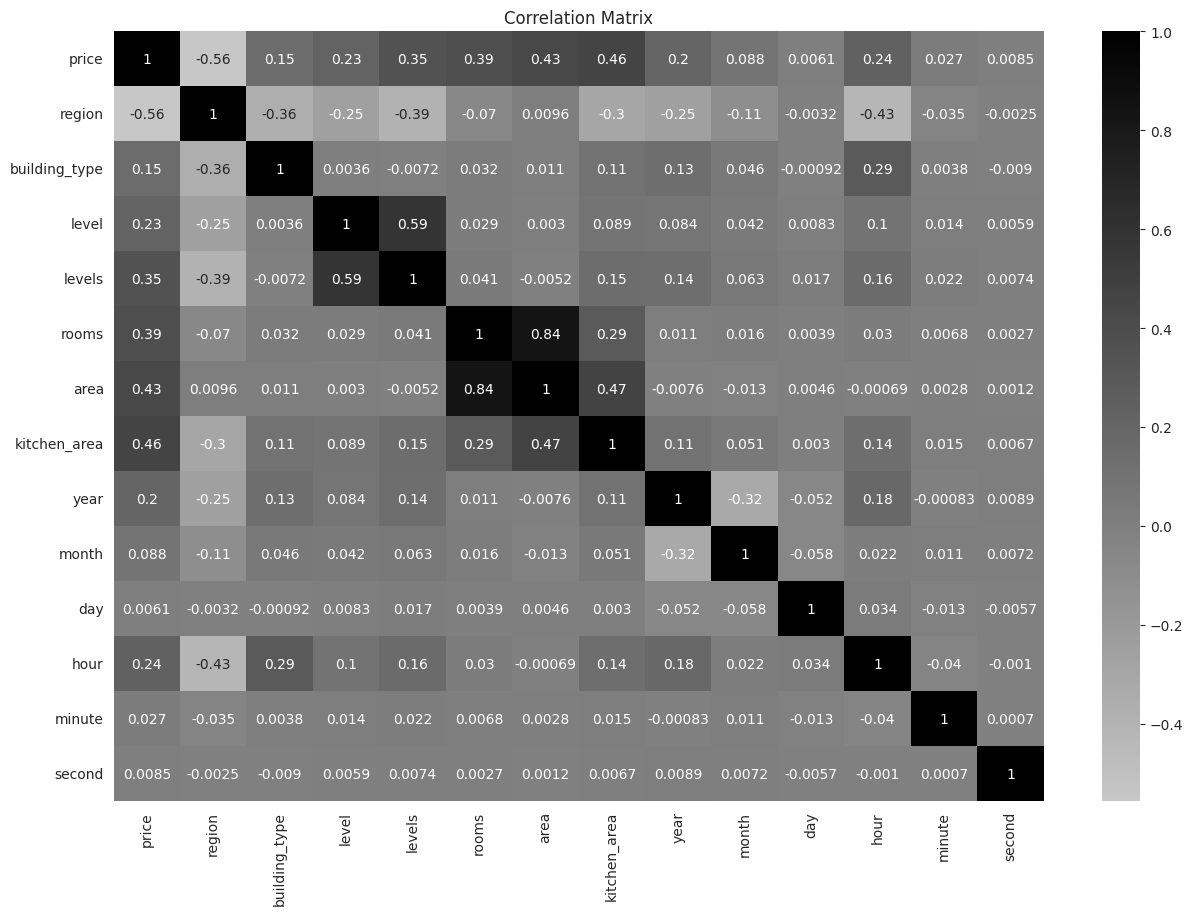

In [ ]:
numeric_columns = list(initial_data.select_dtypes(exclude=['object'],).columns)
plt.figure(figsize=(15, 10))
sns.heatmap(data[numeric_columns].corr(), center=0, cmap='binary', annot=True) #cmap='mako',
plt.title('Correlation Matrix')
plt.show()

Transformations with price

In [ ]:
# plt.figure(figsize=(10,5))
# plt.hist(initial_data["price"].astype(int), ec='black', bins=2000)
# plt.xlabel('Price')
# plt.xlim(0, 30000000)

In [ ]:
# initial_data['price_log']= np.log(initial_data['price'])

In [ ]:
# sns.distplot(initial_data["price_log"], kde=True)
# plt.xlim(13.5, 17.5)
# plt.show()

# Initial data

In [ ]:
initial_data = pd.read_csv('initial_data.csv', sep=',')

In [ ]:
X =initial_data.drop('price', axis=1)
y = initial_data['price']

for cross_validation

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(initial_data.drop('price', axis=1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear regression

In [ ]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

train_base_pred = lr.predict(X_train)
test_base_pred = lr.predict(X_test)

CPU times: user 858 ms, sys: 43 ms, total: 901 ms
Wall time: 816 ms


In [ ]:
RMSE_train_base = root_mean_squared_error(y_train, train_base_pred)
RMSE_test_base = mean_absolute_error(y_test, test_base_pred)

MAE_train_base = mean_absolute_error(y_train, train_base_pred)
MAE_test_base = mean_absolute_error(y_test, test_base_pred)

r2_train_base = r2_score(y_train, train_base_pred)
r2_test_base = r2_score(y_test, test_base_pred)


mape_train_base = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_base = mean_absolute_percentage_error(y_test, test_base_pred)

print("RMSE train: ", round(RMSE_train_base, 2))
print("RMSE test: ", round(RMSE_test_base, 2))
print("r2 train: ", round(r2_train_base, 2))
print("r2 test: ", round(r2_test_base, 2))
print("mape train: ", round(mape_train_base, 2))
print("mape test: ", round(mape_test_base, 2))

RMSE train:  2150736.05
RMSE test:  1503428.21
r2 train:  0.54
r2 test:  0.54
mape train:  7.68
mape test:  19.42


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()

In [ ]:
print(-round(scores, 2))

2140945.2


## Lasso

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    lasso = linear_model.Lasso(alpha=alpha)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores = []
    rmse_scores.append(rmse)

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value (RMSE):", study.best_value)

[I 2025-05-21 14:04:22,595] A new study created in memory with name: no-name-13523325-8dc1-4741-9ba2-718e058fea01
[I 2025-05-21 14:04:29,036] Trial 0 finished with value: 2147641.583141003 and parameters: {'alpha': 0.00019136267846215597}. Best is trial 0 with value: 2147641.583141003.
[I 2025-05-21 14:04:32,944] Trial 1 finished with value: 2147641.583155963 and parameters: {'alpha': 0.0018443844194745217}. Best is trial 0 with value: 2147641.583141003.
[I 2025-05-21 14:04:39,274] Trial 2 finished with value: 2147641.5833074893 and parameters: {'alpha': 0.018556648885683338}. Best is trial 0 with value: 2147641.583141003.
[I 2025-05-21 14:04:43,073] Trial 3 finished with value: 2147641.5840817667 and parameters: {'alpha': 0.10410192604227912}. Best is trial 0 with value: 2147641.583141003.
[I 2025-05-21 14:04:47,160] Trial 4 finished with value: 2147641.5831484958 and parameters: {'alpha': 0.0010187593830199011}. Best is trial 0 with value: 2147641.583141003.
[I 2025-05-21 14:04:51,10

Number of finished trials: 20
Best trial: {'alpha': 0.00010520686494939222}
Best value (RMSE): 2147641.5831402233


In [ ]:
study.best_trial.params

{'alpha': 0.00010520686494939222}

In [ ]:
%%time
lasso = linear_model.Lasso(alpha=0.00010520686494939222, max_iter = 2000)
lasso.fit(X_train, y_train)

train_base_ls = lasso.predict(X_train)
test_base_ls = lasso.predict(X_test)

CPU times: user 11.5 s, sys: 147 ms, total: 11.7 s
Wall time: 8.14 s


In [ ]:
RMSE_train_ls = root_mean_squared_error(y_train, train_base_ls)
RMSE_test_ls = mean_absolute_error(y_test, test_base_ls)

r2_train_ls = r2_score(y_train, train_base_ls)
r2_test_ls = r2_score(y_test, test_base_ls)

mape_train_ls = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_ls = mean_absolute_percentage_error(y_test, test_base_pred)


print("RMSE train: ", round(RMSE_train_ls, 2))
print("RMSE test: ", round(RMSE_test_ls, 2))
print("r2 train: ", round(r2_train_ls, 2))
print("r2 test: ", round(r2_test_ls, 2))
print("mape train: ", round(mape_train_ls, 2))
print("mape test: ", round(mape_test_ls, 2))

RMSE train:  2150736.05
RMSE test:  1503428.21
r2 train:  0.54
r2 test:  0.54
mape train:  7.68
mape test:  19.42


In [ ]:
scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

2140945.2


## Ridge

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    rg = Ridge(alpha=alpha)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    rg.fit(X_train, y_train)
    y_pred = rg.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores = []
    rmse_scores.append(rmse)

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value (RMSE):", study.best_value)

[I 2025-05-21 14:28:41,218] A new study created in memory with name: no-name-66c867d4-5dd3-41f8-a623-e705567d75e2
[I 2025-05-21 14:28:41,382] Trial 0 finished with value: 2147641.5831401725 and parameters: {'alpha': 0.00014739226665332942}. Best is trial 0 with value: 2147641.5831401725.
[I 2025-05-21 14:28:41,523] Trial 1 finished with value: 2147641.5831424966 and parameters: {'alpha': 0.0005264413975231501}. Best is trial 0 with value: 2147641.5831401725.
[I 2025-05-21 14:28:41,690] Trial 2 finished with value: 2147641.5831611753 and parameters: {'alpha': 0.0035723771136066153}. Best is trial 0 with value: 2147641.5831401725.
[I 2025-05-21 14:28:41,836] Trial 3 finished with value: 2147641.586133615 and parameters: {'alpha': 0.48821963552264913}. Best is trial 0 with value: 2147641.5831401725.
[I 2025-05-21 14:28:41,982] Trial 4 finished with value: 2147641.588393085 and parameters: {'alpha': 0.8565083714387384}. Best is trial 0 with value: 2147641.5831401725.
[I 2025-05-21 14:28:42

Number of finished trials: 20
Best trial: {'alpha': 0.00010173819445659532}
Best value (RMSE): 2147641.5831398927


In [ ]:
%%time
model_ridge = Ridge(alpha= 0.00010173819445659532)
model_ridge.fit(X_train, y_train)

train_ridge_pred = model_ridge.predict(X_train)
test_ridge_pred = model_ridge.predict(X_test)

CPU times: user 203 ms, sys: 167 ms, total: 370 ms
Wall time: 477 ms


In [ ]:
RMSE_train_ridge = root_mean_squared_error(y_train, train_ridge_pred)
RMSE_test_ridge = mean_absolute_error(y_test, test_ridge_pred)

r2_train_ridge = r2_score(y_train, train_ridge_pred)
r2_test_ridge = r2_score(y_test, test_ridge_pred)

mape_train_ridge = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_ridge = mean_absolute_percentage_error(y_test, test_base_pred)


print("RMSE train: ", round(RMSE_train_ridge, 2))
print("RMSE test: ", round(RMSE_test_ridge, 2))
print("r2 train: ", round(r2_train_ridge, 2))
print("r2 test: ", round(r2_test_ridge, 2))
print("mape train: ", round(mape_train_ridge, 2))
print("mape test: ", round(mape_test_ridge, 2))

RMSE train:  2150736.05
RMSE test:  1503428.21
r2 train:  0.54
r2 test:  0.54
mape train:  7.68
mape test:  19.42


In [ ]:
scores = cross_val_score(model_ridge,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

2140945.2


## Bagging

Подбор параметров происходил ручным способом

In [ ]:
%%time
regr = BaggingRegressor(n_estimators=15,
                        random_state=42,
                        n_jobs=-1,
                        max_samples=0.1,
                        warm_start =True
                        )
regr.fit(X_train, y_train)

train_pred = regr.predict(X_train)
test_pred = regr.predict(X_test)

CPU times: user 546 ms, sys: 877 ms, total: 1.42 s
Wall time: 31.8 s


In [ ]:
RMSE_train_bag = root_mean_squared_error(y_train, train_pred)
RMSE_test_bag = mean_absolute_error(y_test, test_pred)

r2_train_bag = r2_score(y_train, train_pred)
r2_test_bag = r2_score(y_test, test_pred)

mape_train_bag = mean_absolute_percentage_error(y_train, train_pred)
mape_test_bag = mean_absolute_percentage_error(y_test, test_pred)


print("RMSE train: ", round(RMSE_train_bag, 2))
print("RMSE test: ", round(RMSE_test_bag, 2))
print("r2 train: ", round(r2_train_bag, 2))
print("r2 test: ", round(r2_test_bag, 2))
print("mape train: ", round(mape_train_bag, 2))
print("mape test: ", round(mape_test_bag, 2))

RMSE train:  875059.51
RMSE test:  505464.78
r2 train:  0.92
r2 test:  0.91
mape train:  3.43
mape test:  17.49


In [ ]:
scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1123696.08


##Gradient Boosting

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 7)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    loss = "squared_error"

    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           learning_rate=learning_rate,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           min_samples_leaf=min_samples_leaf,
                                           subsample=subsample,
                                           loss=loss,
                                           random_state=42)
    model.fit(X_train, y_train)

    test_rf_pred = model.predict(X_test)
    test_rf = root_mean_squared_error(test_rf_pred, y_test)


    return test_rf

In [ ]:
study = optuna.create_study(direction="minimize") # Minimize RMSE
study.optimize(objective, n_trials=3)

[I 2025-05-21 15:01:21,877] A new study created in memory with name: no-name-6a6dcf74-a8c8-4877-b823-32bee377cbcc
[I 2025-05-21 15:32:14,955] Trial 0 finished with value: 1076651.087671378 and parameters: {'n_estimators': 384, 'learning_rate': 0.026142845576372677, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.8348356808567711}. Best is trial 0 with value: 1076651.087671378.
[I 2025-05-21 16:05:02,808] Trial 1 finished with value: 1064929.586601874 and parameters: {'n_estimators': 488, 'learning_rate': 0.051266598614750504, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.8604099292563616}. Best is trial 1 with value: 1064929.586601874.
[I 2025-05-21 16:31:30,833] Trial 2 finished with value: 1006527.5040332325 and parameters: {'n_estimators': 250, 'learning_rate': 0.06616966493089971, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.9731673929626468}. Best is trial 2 with value: 1006527.504033232

In [ ]:
study.best_params

{'n_estimators': 250,
 'learning_rate': 0.06616966493089971,
 'max_depth': 7,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'subsample': 0.9731673929626468}

In [ ]:
%%time
gb = GradientBoostingRegressor(n_estimators= 250,
                                learning_rate= 0.06616966493089971,
                                max_depth=7,
                                min_samples_split=6,
                                min_samples_leaf=5,
                                subsample= 0.9731673929626468,
                                loss='squared_error',
                                random_state=42)
gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)

CPU times: user 22min 36s, sys: 1.63 s, total: 22min 37s
Wall time: 22min 48s


In [ ]:
RMSE_train_gb = root_mean_squared_error(y_train, train_pred)
RMSE_test_gb = mean_absolute_error(y_test, test_pred)

r2_train_gb = r2_score(y_train, train_pred)
r2_test_gb = r2_score(y_test, test_pred)

mape_train_gb = mean_absolute_percentage_error(y_train, train_pred)
mape_test_gb = mean_absolute_percentage_error(y_test, test_pred)


print("RMSE train: ", round(RMSE_train_gb, 2))
print("RMSE test: ", round(RMSE_test_gb, 2))
print("r2 train: ", round(r2_train_gb, 2))
print("r2 test: ", round(r2_test_gb, 2))
print("mape train: ", round(mape_train_gb, 2))
print("mape test: ", round(mape_test_gb, 2))

RMSE train:  992186.02
RMSE test:  580426.68
r2 train:  0.9
r2 test:  0.9
mape train:  4.07
mape test:  19.14


In [ ]:
scores = cross_val_score(gb,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1104015.64


## RandomForestRegressor

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    test_rf_pred = model.predict(X_test)
    test_rf = root_mean_squared_error(test_rf_pred, y_test)


    return test_rf

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2025-05-22 10:45:28,074] A new study created in memory with name: no-name-791627c9-79be-415b-b1d7-c3b2cdd6c1d6
[I 2025-05-22 10:51:54,911] Trial 0 finished with value: 940760.7240396116 and parameters: {'n_estimators': 128, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.508218881160258}. Best is trial 0 with value: 940760.7240396116.
[I 2025-05-22 10:56:49,142] Trial 1 finished with value: 1451932.9248016474 and parameters: {'n_estimators': 128, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.9893992034948995}. Best is trial 0 with value: 940760.7240396116.
[I 2025-05-22 11:07:24,383] Trial 2 finished with value: 779751.797710845 and parameters: {'n_estimators': 133, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.5675945454156726}. Best is trial 2 with value: 779751.797710845.
[I 2025-05-22 11:12:18,300] Trial 3 finished with value: 1215749.0468374211 and parameters: {'n_estimators

In [ ]:
study.best_trial.params

{'n_estimators': 133,
 'max_depth': 42,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 0.5675945454156726}

In [ ]:
%%time
best_rf = RandomForestRegressor(n_estimators=133,
                          max_depth=42,
                          min_samples_split= 7,
                          min_samples_leaf= 3,
                          max_features= 0.5675945454156726)
best_rf.fit(X_train, y_train)

train_rf_pred = best_rf.predict(X_train)
test_rf_pred = best_rf.predict(X_test)

CPU times: user 15min 49s, sys: 3.8 s, total: 15min 52s
Wall time: 16min 2s


In [ ]:
RMSE_train_rf = root_mean_squared_error(y_train, train_rf_pred)
RMSE_test_rf = mean_absolute_error(y_test, test_rf_pred)

r2_train_rf = r2_score(y_train, train_rf_pred)
r2_test_rf = r2_score(y_test, test_rf_pred)

mape_train_rf = mean_absolute_percentage_error(y_train, train_rf_pred)
mape_test_rf = mean_absolute_percentage_error(y_test, test_rf_pred)


print("RMSE train: ", round(RMSE_train_rf, 2))
print("RMSE test: ", round(RMSE_test_rf, 2))
print("r2 train: ", round(r2_train_rf, 2))
print("r2 test: ", round(r2_test_rf, 2))
print("mape train: ", round(mape_train_rf, 2))
print("mape test: ", round(mape_test_rf, 2))

RMSE train:  487742.51
RMSE test:  373777.02
r2 train:  0.98
r2 test:  0.94
mape train:  2.73
mape test:  16.51


In [ ]:
scores = cross_val_score(best_rf,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1002039.48


## LGBMRegressor

In [ ]:
initial_data['region'] = pd.to_numeric(initial_data['region'], errors='raise')

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    num_leaves = trial.suggest_int('num_leaves', 5, 100)
    min_child_samples = trial.suggest_int('min_child_samples', 20, 50)
    subsample = trial.suggest_float('subsample', 0.2, 1.0)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    test_rf_pred = model.predict(X_test)
    rmse_test_rf = root_mean_squared_error(y_test, test_rf_pred)


    return rmse_test_rf

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-05-22 13:03:44,195] A new study created in memory with name: no-name-7cb3f036-27c5-4fd2-b54f-0896a0486ce1
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:04:20,121] Trial 0 finished with value: 1076467.132175301 and parameters: {'n_estimators': 477, 'max_depth': 27, 'learning_rate': 0.09173204968000008, 'num_leaves': 10, 'min_child_samples': 35, 'subsample': 0.38923943890855184}. Best is trial 0 with value: 1076467.132175301.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:04:56,723] Trial 1 finished with value: 922114.6377651589 and parameters: {'n_estimators': 372, 'max_depth': 16, 'learning_rate': 0.08810653149918593, 'num_leaves': 96, 'min_child_samples': 43, 'subsample': 0.7904459161089092}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:05:38,178] Trial 2 finished with value: 922367.4450050929 and parameters: {'n_estimators': 401, 'max_depth': 20, 'learning_rate': 0.09199553791047636, 'num_leaves': 79, 'min_child_samples': 44, 'subsample': 0.7363400045629918}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:06:02,234] Trial 3 finished with value: 1119027.8637123627 and parameters: {'n_estimators': 179, 'max_depth': 8, 'learning_rate': 0.031221387293097633, 'num_leaves': 39, 'min_child_samples': 25, 'subsample': 0.816141827651985}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.320538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:06:53,225] Trial 4 finished with value: 944242.8811882889 and parameters: {'n_estimators': 499, 'max_depth': 22, 'learning_rate': 0.0868602722210391, 'num_leaves': 53, 'min_child_samples': 31, 'subsample': 0.6151775222168512}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:07:12,662] Trial 5 finished with value: 1290284.3569074876 and parameters: {'n_estimators': 308, 'max_depth': 2, 'learning_rate': 0.07752554989474782, 'num_leaves': 28, 'min_child_samples': 32, 'subsample': 0.4975607158375647}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:07:27,085] Trial 6 finished with value: 1286980.2981252158 and parameters: {'n_estimators': 124, 'max_depth': 44, 'learning_rate': 0.02477907447872093, 'num_leaves': 18, 'min_child_samples': 48, 'subsample': 0.8035272382409362}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:07:56,692] Trial 7 finished with value: 1094435.1881930574 and parameters: {'n_estimators': 353, 'max_depth': 38, 'learning_rate': 0.054510742644072324, 'num_leaves': 15, 'min_child_samples': 41, 'subsample': 0.8897441977849747}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:08:21,145] Trial 8 finished with value: 1119563.8145781392 and parameters: {'n_estimators': 153, 'max_depth': 9, 'learning_rate': 0.02401417644826992, 'num_leaves': 67, 'min_child_samples': 36, 'subsample': 0.8776853606638666}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:09:11,316] Trial 9 finished with value: 978881.2888117878 and parameters: {'n_estimators': 446, 'max_depth': 47, 'learning_rate': 0.04395700583930709, 'num_leaves': 64, 'min_child_samples': 41, 'subsample': 0.5493664820692528}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:09:46,352] Trial 10 finished with value: 956917.1690467764 and parameters: {'n_estimators': 235, 'max_depth': 32, 'learning_rate': 0.07027186836723681, 'num_leaves': 97, 'min_child_samples': 20, 'subsample': 0.9949430838552401}. Best is trial 1 with value: 922114.6377651589.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:10:26,661] Trial 11 finished with value: 906497.8147207019 and parameters: {'n_estimators': 393, 'max_depth': 17, 'learning_rate': 0.09959704982227967, 'num_leaves': 97, 'min_child_samples': 49, 'subsample': 0.7143637201474505}. Best is trial 11 with value: 906497.8147207019.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:11:04,065] Trial 12 finished with value: 916259.0589704737 and parameters: {'n_estimators': 355, 'max_depth': 15, 'learning_rate': 0.09886041011185388, 'num_leaves': 99, 'min_child_samples': 50, 'subsample': 0.6702762476667128}. Best is trial 11 with value: 906497.8147207019.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:11:32,913] Trial 13 finished with value: 939045.8740005011 and parameters: {'n_estimators': 284, 'max_depth': 15, 'learning_rate': 0.099365952715874, 'num_leaves': 83, 'min_child_samples': 50, 'subsample': 0.23365564976602288}. Best is trial 11 with value: 906497.8147207019.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:12:14,923] Trial 14 finished with value: 933654.825584988 and parameters: {'n_estimators': 410, 'max_depth': 29, 'learning_rate': 0.07185995460548066, 'num_leaves': 83, 'min_child_samples': 47, 'subsample': 0.6526440038033917}. Best is trial 11 with value: 906497.8147207019.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:12:56,920] Trial 15 finished with value: 958227.3762702106 and parameters: {'n_estimators': 319, 'max_depth': 11, 'learning_rate': 0.06038198648498262, 'num_leaves': 100, 'min_child_samples': 50, 'subsample': 0.4495658932299904}. Best is trial 11 with value: 906497.8147207019.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:13:08,842] Trial 16 finished with value: 1607167.3183150915 and parameters: {'n_estimators': 233, 'max_depth': 1, 'learning_rate': 0.07992809109701994, 'num_leaves': 72, 'min_child_samples': 45, 'subsample': 0.6817652824761053}. Best is trial 11 with value: 906497.8147207019.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:13:51,695] Trial 17 finished with value: 904858.6727145268 and parameters: {'n_estimators': 434, 'max_depth': 20, 'learning_rate': 0.09777801671473886, 'num_leaves': 89, 'min_child_samples': 39, 'subsample': 0.3438714042534819}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:14:56,532] Trial 18 finished with value: 1106971.8649464066 and parameters: {'n_estimators': 435, 'max_depth': 34, 'learning_rate': 0.010507164480063808, 'num_leaves': 53, 'min_child_samples': 39, 'subsample': 0.30033742305143823}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:15:42,850] Trial 19 finished with value: 934553.6702280509 and parameters: {'n_estimators': 453, 'max_depth': 24, 'learning_rate': 0.060890629536812485, 'num_leaves': 88, 'min_child_samples': 27, 'subsample': 0.3537075755157204}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:16:26,251] Trial 20 finished with value: 976411.2013773363 and parameters: {'n_estimators': 373, 'max_depth': 18, 'learning_rate': 0.04619435648051395, 'num_leaves': 73, 'min_child_samples': 38, 'subsample': 0.21342578042699517}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:17:01,542] Trial 21 finished with value: 926448.668172867 and parameters: {'n_estimators': 345, 'max_depth': 13, 'learning_rate': 0.09544423827672413, 'num_leaves': 91, 'min_child_samples': 47, 'subsample': 0.5654648589340436}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:17:53,265] Trial 22 finished with value: 993296.9838963841 and parameters: {'n_estimators': 409, 'max_depth': 6, 'learning_rate': 0.09857186598178934, 'num_leaves': 100, 'min_child_samples': 46, 'subsample': 0.7209562347651198}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:18:26,040] Trial 23 finished with value: 945973.9499437392 and parameters: {'n_estimators': 274, 'max_depth': 21, 'learning_rate': 0.0820069757296201, 'num_leaves': 91, 'min_child_samples': 49, 'subsample': 0.4864496522187363}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:19:05,238] Trial 24 finished with value: 927735.0809194553 and parameters: {'n_estimators': 392, 'max_depth': 17, 'learning_rate': 0.08677594564090756, 'num_leaves': 80, 'min_child_samples': 43, 'subsample': 0.6026578641013629}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:19:35,371] Trial 25 finished with value: 951453.6773685815 and parameters: {'n_estimators': 333, 'max_depth': 25, 'learning_rate': 0.09945897954292134, 'num_leaves': 60, 'min_child_samples': 33, 'subsample': 0.6915114594712222}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:20:18,227] Trial 26 finished with value: 979781.926057382 and parameters: {'n_estimators': 428, 'max_depth': 14, 'learning_rate': 0.07161036240469153, 'num_leaves': 43, 'min_child_samples': 41, 'subsample': 0.4065076689069662}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:21:03,255] Trial 27 finished with value: 1040249.8198569054 and parameters: {'n_estimators': 463, 'max_depth': 5, 'learning_rate': 0.08286026318646159, 'num_leaves': 90, 'min_child_samples': 29, 'subsample': 0.5313713258476254}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:21:42,094] Trial 28 finished with value: 935922.6080655395 and parameters: {'n_estimators': 365, 'max_depth': 12, 'learning_rate': 0.09231357253132358, 'num_leaves': 77, 'min_child_samples': 38, 'subsample': 0.2860561476072913}. Best is trial 17 with value: 904858.6727145268.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:22:38,715] Trial 29 finished with value: 902328.4565887477 and parameters: {'n_estimators': 484, 'max_depth': 29, 'learning_rate': 0.09170517927014152, 'num_leaves': 90, 'min_child_samples': 34, 'subsample': 0.7540854048814771}. Best is trial 29 with value: 902328.4565887477.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:23:28,539] Trial 30 finished with value: 914585.2286124694 and parameters: {'n_estimators': 495, 'max_depth': 29, 'learning_rate': 0.07665006619921896, 'num_leaves': 86, 'min_child_samples': 34, 'subsample': 0.9132417890530546}. Best is trial 29 with value: 902328.4565887477.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:24:12,457] Trial 31 finished with value: 904519.1996324186 and parameters: {'n_estimators': 499, 'max_depth': 28, 'learning_rate': 0.09112541318938844, 'num_leaves': 87, 'min_child_samples': 35, 'subsample': 0.9664854349568517}. Best is trial 29 with value: 902328.4565887477.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:24:57,934] Trial 32 finished with value: 904507.3708678643 and parameters: {'n_estimators': 471, 'max_depth': 36, 'learning_rate': 0.08992140211740347, 'num_leaves': 92, 'min_child_samples': 37, 'subsample': 0.9946083422171594}. Best is trial 29 with value: 902328.4565887477.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:25:42,131] Trial 33 finished with value: 916170.2450466728 and parameters: {'n_estimators': 471, 'max_depth': 38, 'learning_rate': 0.09022569393714541, 'num_leaves': 76, 'min_child_samples': 36, 'subsample': 0.9981087025394602}. Best is trial 29 with value: 902328.4565887477.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:26:29,655] Trial 34 finished with value: 897403.4886542144 and parameters: {'n_estimators': 481, 'max_depth': 37, 'learning_rate': 0.09156438689536536, 'num_leaves': 92, 'min_child_samples': 35, 'subsample': 0.9455596859036517}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:27:14,540] Trial 35 finished with value: 922038.5907115545 and parameters: {'n_estimators': 485, 'max_depth': 39, 'learning_rate': 0.0875379396058537, 'num_leaves': 71, 'min_child_samples': 35, 'subsample': 0.9342856200286352}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:27:59,944] Trial 36 finished with value: 899510.9854506659 and parameters: {'n_estimators': 473, 'max_depth': 34, 'learning_rate': 0.09342404136155302, 'num_leaves': 92, 'min_child_samples': 30, 'subsample': 0.8430607714460441}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:28:38,307] Trial 37 finished with value: 971696.4084745896 and parameters: {'n_estimators': 469, 'max_depth': 42, 'learning_rate': 0.085539306812583, 'num_leaves': 38, 'min_child_samples': 31, 'subsample': 0.8448524221010048}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:29:32,894] Trial 38 finished with value: 909631.9578748266 and parameters: {'n_estimators': 475, 'max_depth': 34, 'learning_rate': 0.07584116724483544, 'num_leaves': 94, 'min_child_samples': 29, 'subsample': 0.7707212288961565}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:30:18,743] Trial 39 finished with value: 937521.2968375155 and parameters: {'n_estimators': 417, 'max_depth': 32, 'learning_rate': 0.06613035221319272, 'num_leaves': 81, 'min_child_samples': 24, 'subsample': 0.8477362454721984}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:31:00,483] Trial 40 finished with value: 934010.8967477853 and parameters: {'n_estimators': 452, 'max_depth': 48, 'learning_rate': 0.09411294921682009, 'num_leaves': 59, 'min_child_samples': 30, 'subsample': 0.7840447271303377}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:31:51,065] Trial 41 finished with value: 900365.5686954828 and parameters: {'n_estimators': 499, 'max_depth': 36, 'learning_rate': 0.09053244275037554, 'num_leaves': 93, 'min_child_samples': 33, 'subsample': 0.9481397084356511}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:32:38,194] Trial 42 finished with value: 900493.5223843501 and parameters: {'n_estimators': 481, 'max_depth': 41, 'learning_rate': 0.08387225431731955, 'num_leaves': 94, 'min_child_samples': 33, 'subsample': 0.9410520524258162}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:33:28,139] Trial 43 finished with value: 902533.606124811 and parameters: {'n_estimators': 500, 'max_depth': 43, 'learning_rate': 0.08423974136578292, 'num_leaves': 95, 'min_child_samples': 33, 'subsample': 0.9456108885789996}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:34:11,203] Trial 44 finished with value: 909609.125120789 and parameters: {'n_estimators': 450, 'max_depth': 32, 'learning_rate': 0.0931567515566678, 'num_leaves': 85, 'min_child_samples': 26, 'subsample': 0.8803347760593248}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:35:01,418] Trial 45 finished with value: 905968.6568332361 and parameters: {'n_estimators': 488, 'max_depth': 39, 'learning_rate': 0.07942497602547965, 'num_leaves': 95, 'min_child_samples': 32, 'subsample': 0.8495065300889184}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:35:27,998] Trial 46 finished with value: 1163316.1504078682 and parameters: {'n_estimators': 430, 'max_depth': 45, 'learning_rate': 0.08781586172815573, 'num_leaves': 5, 'min_child_samples': 28, 'subsample': 0.904150543776276}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:36:04,399] Trial 47 finished with value: 949478.056599441 and parameters: {'n_estimators': 388, 'max_depth': 41, 'learning_rate': 0.07403344355683919, 'num_leaves': 67, 'min_child_samples': 23, 'subsample': 0.8163359993275864}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:36:47,113] Trial 48 finished with value: 919335.0481603661 and parameters: {'n_estimators': 482, 'max_depth': 36, 'learning_rate': 0.0817272182683143, 'num_leaves': 78, 'min_child_samples': 31, 'subsample': 0.7521618622837196}. Best is trial 34 with value: 897403.4886542144.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-22 13:37:27,172] Trial 49 finished with value: 911003.4469708125 and parameters: {'n_estimators': 459, 'max_depth': 35, 'learning_rate': 0.09494572913227123, 'num_leaves': 83, 'min_child_samples': 33, 'subsample': 0.9581864790946472}. Best is trial 34 with value: 897403.4886542144.


In [ ]:
print("Лучшие параметры:", study.best_params)
print("Лучшее значение метрики:", study.best_value)

Лучшие параметры: {'n_estimators': 481, 'max_depth': 37, 'learning_rate': 0.09156438689536536, 'num_leaves': 92, 'min_child_samples': 35, 'subsample': 0.9455596859036517}
Лучшее значение метрики: 897403.4886542144


In [ ]:
%%time
lg = LGBMRegressor(n_estimators= 481,
                    max_depth= 37,
                    learning_rate= 0.09156438689536536,
                    num_leaves= 92,
                    min_child_samples= 35,
                    subsample= 0.9455596859036517)
lg.fit(X_train, y_train)

train_lg_pred = lg.predict(X_train)
test_lg_pred = lg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 1min 31s, sys: 223 ms, total: 1min 31s
Wall time: 1min 31s


In [ ]:
RMSE_train_lgmr = root_mean_squared_error(y_train, train_lg_pred)
RMSE_test_lgmr = mean_absolute_error(y_test, test_lg_pred)

r2_train_lgmr = r2_score(y_train, train_lg_pred)
r2_test_lgmr = r2_score(y_test, test_lg_pred)

mape_train_lgmr = mean_absolute_percentage_error(y_train, train_lg_pred)
mape_test_lgmr = mean_absolute_percentage_error(y_test, test_lg_pred)


print("RMSE train: ", round(RMSE_train_lgmr, 2))
print("RMSE test: ", round(RMSE_test_lgmr, 2))
print("r2 train: ", round(r2_train_lgmr, 2))
print("r2 test: ", round(r2_test_lgmr, 2))
print("mape train: ", round(mape_train_lgmr, 2))
print("mape test: ", round(mape_test_lgmr, 2))

RMSE train:  856735.78
RMSE test:  512911.77
r2 train:  0.93
r2 test:  0.92
mape train:  3.61
mape test:  18.08


In [ ]:
scores = cross_val_score(lg,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 4090809.731896


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 4140782.470607


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 4091227.221503


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 13
[LightGBM] [Info] Start training from score 3751778.737789


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 1140392, number of used features: 13
[LightGBM] [Info] Start training from score 3614272.422946


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1054110.9


## XGBRegressor

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 250, 50),
        'seed': 0
    }

In [ ]:
def objective(space):
    xgbrb = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=space['seed'],
        tree_method='gpu_hist',
        n_jobs=-1
    )

    xgbrb.fit(X_train, y_train)
    test_xgbrb_pred = xgbrb.predict(X_test)
    mae_test_xgbrb = mean_absolute_error(y_test, test_xgbrb_pred)


    return mae_test_xgbrb

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu

 10%|█         | 1/10 [00:04<00:36,  4.09s/trial, best loss: 613954.1505228027]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 20%|██        | 2/10 [00:18<01:19,  9.90s/trial, best loss: 457551.28635504283]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 30%|███       | 3/10 [00:44<02:03, 17.60s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 40%|████      | 4/10 [00:48<01:12, 12.10s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 50%|█████     | 5/10 [00:55<00:52, 10.44s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 60%|██████    | 6/10 [01:00<00:34,  8.56s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 70%|███████   | 7/10 [01:35<00:51, 17.17s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 80%|████████  | 8/10 [01:39<00:26, 13.01s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 9/10 [01:47<00:11, 11.20s/trial, best loss: 407549.31065282814]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



100%|██████████| 10/10 [01:50<00:00, 11.02s/trial, best loss: 407549.31065282814]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



In [ ]:
best_hyperparams

{'colsample_bytree': np.float64(0.9834410208422923),
 'gamma': np.float64(3.502211012043797),
 'max_depth': np.float64(17.0),
 'min_child_weight': np.float64(10.0),
 'n_estimators': np.float64(150.0),
 'reg_alpha': np.float64(151.0),
 'reg_lambda': np.float64(0.8157487566884981)}

In [ ]:
%%time
xgbr = XGBRegressor(colsample_bytree = 0.9834410208422923,
                    gamma = 3.502211012043797,
                    max_depth = 17,
                    min_child_weight = 10,
                    n_estimators = 150,
                    reg_alpha = 151,
                    reg_lambda = 0.8157487566884981,
                    device='cuda',
                    tree_method='gpu_hist',
                    n_jobs=-1
                    )
xgbr.fit(X_train, y_train)
train_xgbr_pred = xgbr.predict(X_train)
test_xgbr_pred = xgbr.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


CPU times: user 29.7 s, sys: 368 ms, total: 30.1 s
Wall time: 33.8 s


In [ ]:
RMSE_train_base = root_mean_squared_error(y_train, train_xgbr_pred)
RMSE_test_base = mean_absolute_error(y_test, test_xgbr_pred)

MAE_train_base = mean_absolute_error(y_train, train_xgbr_pred)
MAE_test_base = mean_absolute_error(y_test, test_xgbr_pred)

r2_train_base = r2_score(y_train, train_xgbr_pred)
r2_test_base = r2_score(y_test, test_xgbr_pred)


mape_train_base = mean_absolute_percentage_error(y_train, train_xgbr_pred)
mape_test_base = mean_absolute_percentage_error(y_test, test_xgbr_pred)


print("RMSE train: ", round(RMSE_train_base, 2))
print("RMSE test: ", round(RMSE_test_base, 2))
print("r2 train: ", round(r2_train_base, 2))
print("r2 test: ", round(r2_test_base, 2))
print("mape train: ", round(mape_train_base, 2))
print("mape test: ", round(mape_test_base, 2))

RMSE train:  159612.17
RMSE test:  407549.31
r2 train:  1.0
r2 test:  0.94
mape train:  0.61
mape test:  17.02


In [ ]:
scores = cross_val_score(xgbr,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

1071000.34


# Data with external columns

In [ ]:
# data_with_external_col = pd.read_csv('data_with_external_col.csv', sep=',')

In [ ]:
data_with_external_col

,price,region,building_type,level,levels,rooms,area,kitchen_area,rate,year,...,inflation,unemployment rate,total fertility rate,average nominal wage,month,day,hour,minute,second,covid
0,1850000.00,2843,4,12,16,2,38.00,5.00,7.75,2018,...,2.88,4.85,-1.58,43724,3,1,11,24,52,0
1,4704280.00,3,2,1,25,1,31.70,6.00,7.75,2018,...,2.88,4.85,-1.58,43724,3,4,12,35,25,0
2,3390000.00,3106,2,4,24,2,64.00,13.00,7.75,2018,...,2.88,4.85,-1.58,43724,3,5,7,7,5,0
3,6909880.00,81,1,9,14,3,76.10,8.80,7.75,2018,...,2.88,4.85,-1.58,43724,3,6,18,34,48,0
4,4291950.00,81,1,10,14,1,40.30,11.00,7.75,2018,...,2.88,4.85,-1.58,43724,3,6,18,37,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425484,11230310.00,3,2,14,17,2,63.70,20.90,4.50,2020,...,3.38,5.59,-1.50,51344,12,30,23,46,43,1
1425485,3379400.00,2722,3,6,18,2,55.40,10.10,4.50,2020,...,3.38,5.59,-1.50,51344,12,30,23,51,44,1
1425486,11217601.00,3,2,4,22,3,70.60,14.20,4.50,2020,...,3.38,5.59,-1.50,51344,12,30,23,53,53,1
1425487,13476010.00,3,2,3,17,3,89.90,19.10,4.50,2020,...,3.38,5.59,-1.50,51344,12,30,23,57,11,1


In [ ]:
X =data_with_external_col.drop('price', axis=1)
y = data_with_external_col['price']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_with_external_col.drop('price', axis=1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear regression

In [ ]:
%%time
model_base = LinearRegression()
model_base.fit(X_train, y_train)

train_base_pred = model_base.predict(X_train)
test_base_pred = model_base.predict(X_test)

CPU times: user 1.38 s, sys: 99.3 ms, total: 1.48 s
Wall time: 1.17 s


In [ ]:
RMSE_train_base = root_mean_squared_error(y_train, train_base_pred)
RMSE_test_base = mean_absolute_error(y_test, test_base_pred)

MAE_train_base = mean_absolute_error(y_train, train_base_pred)
MAE_test_base = mean_absolute_error(y_test, test_base_pred)

r2_train_base = r2_score(y_train, train_base_pred)
r2_test_base = r2_score(y_test, test_base_pred)


mape_train_base = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_base = mean_absolute_percentage_error(y_test, test_base_pred)

print("RMSE train: ", round(RMSE_train_base, 2))
print("RMSE test: ", round(RMSE_test_base, 2))
print("r2 train: ", round(r2_train_base, 2))
print("r2 test: ", round(r2_test_base, 2))
print("mape train: ", round(mape_train_base, 2))
print("mape test: ", round(mape_test_base, 2))

RMSE train:  2149484.49
RMSE test:  1502804.44
r2 train:  0.54
r2 test:  0.54
mape train:  7.74
mape test:  19.69


In [ ]:
scores = cross_val_score(model_base, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

2148986.98


## Lasso

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    lasso = linear_model.Lasso(alpha=alpha)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores = []
    rmse_scores.append(rmse)

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value (RMSE):", study.best_value)

[I 2025-05-22 14:06:24,879] A new study created in memory with name: no-name-52f45846-f8a9-4361-be21-0a0569ddab13
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+17, tolerance: 1.147e+15
  model = cd_fast.enet_coordinate_descent(
[I 2025-05-22 14:08:49,882] Trial 0 finished with value: 2146445.9413371226 and parameters: {'alpha': 0.002108801683403804}. Best is trial 0 with value: 2146445.9413371226.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e+15, tolerance: 1.147e+15
  model = cd_fast.enet_coordinate_descent(
[I 2025-05-22 1

Number of finished trials: 10
Best trial: {'alpha': 0.001463212251295911}
Best value (RMSE): 2146445.9413328674


In [ ]:
study.best_trial.params

{'alpha': 0.001463212251295911}

In [ ]:
%%time
lasso = linear_model.Lasso(alpha= 0.001463212251295911, max_iter = 5000)
lasso.fit(X_train, y_train)

train_base_ls = lasso.predict(X_train)
test_base_ls = lasso.predict(X_test)

CPU times: user 13min, sys: 1.66 s, total: 13min 2s
Wall time: 7min 47s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+17, tolerance: 1.147e+15
  model = cd_fast.enet_coordinate_descent(


In [ ]:
RMSE_train_ls = root_mean_squared_error(y_train, train_base_ls)
RMSE_test_ls = mean_absolute_error(y_test, test_base_ls)

r2_train_ls = r2_score(y_train, train_base_ls)
r2_test_ls = r2_score(y_test, test_base_ls)

mape_train_ls = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_ls = mean_absolute_percentage_error(y_test, test_base_pred)


print("RMSE train: ", round(RMSE_train_ls, 2))
print("RMSE test: ", round(RMSE_test_ls, 2))
print("r2 train: ", round(r2_train_ls, 2))
print("r2 test: ", round(r2_test_ls, 2))
print("mape train: ", round(mape_train_ls, 2))
print("mape test: ", round(mape_test_ls, 2))

RMSE train:  2149484.49
RMSE test:  1502804.44
r2 train:  0.54
r2 test:  0.54
mape train:  7.74
mape test:  19.69


In [ ]:
scores = cross_val_score(lasso,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.324e+15, tolerance: 1.195e+15
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+17, tolerance: 1.208e+15
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e+17, tolerance: 1.179e

2152223.87


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+16, tolerance: 1.013e+15
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(-round(scores, 2))

2152223.87


## Ridge

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    rg = Ridge(alpha=alpha)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    rg.fit(X_train, y_train)
    y_pred = rg.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores = []
    rmse_scores.append(rmse)

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value (RMSE):", study.best_value)

[I 2025-05-22 19:21:55,751] A new study created in memory with name: no-name-5b624fd5-e5b4-4752-8cff-55afb8481eaa
[I 2025-05-22 19:21:56,390] Trial 0 finished with value: 2146445.9415684757 and parameters: {'alpha': 0.03757097622506883}. Best is trial 0 with value: 2146445.9415684757.
[I 2025-05-22 19:21:56,655] Trial 1 finished with value: 2146445.9413625957 and parameters: {'alpha': 0.006031738023468346}. Best is trial 1 with value: 2146445.9413625957.
[I 2025-05-22 19:21:56,914] Trial 2 finished with value: 2146445.9446138456 and parameters: {'alpha': 0.5040208961588433}. Best is trial 1 with value: 2146445.9413625957.
[I 2025-05-22 19:21:57,166] Trial 3 finished with value: 2146445.947208711 and parameters: {'alpha': 0.9013528361194744}. Best is trial 1 with value: 2146445.9413625957.
[I 2025-05-22 19:21:57,422] Trial 4 finished with value: 2146445.9427633234 and parameters: {'alpha': 0.2205996437215146}. Best is trial 1 with value: 2146445.9413625957.
[I 2025-05-22 19:21:57,678] T

Number of finished trials: 20
Best trial: {'alpha': 0.00010698525780084521}
Best value (RMSE): 2146445.941323921


In [ ]:
study.best_trial.params

{'alpha': 0.00010698525780084521}

In [ ]:
%%time
model_ridge = Ridge(**study.best_trial.params)
model_ridge.fit(X_train, y_train)

train_ridge_pred = model_ridge.predict(X_train)
test_ridge_pred = model_ridge.predict(X_test)

CPU times: user 368 ms, sys: 39.8 ms, total: 408 ms
Wall time: 283 ms


In [ ]:
RMSE_train_ridge = root_mean_squared_error(y_train, train_ridge_pred)
RMSE_test_ridge = mean_absolute_error(y_test, test_ridge_pred)

r2_train_ridge = r2_score(y_train, train_ridge_pred)
r2_test_ridge = r2_score(y_test, test_ridge_pred)

mape_train_ridge = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_ridge = mean_absolute_percentage_error(y_test, test_base_pred)


print("RMSE train: ", round(RMSE_train_ridge, 2))
print("RMSE test: ", round(RMSE_test_ridge, 2))
print("r2 train: ", round(r2_train_ridge, 2))
print("r2 test: ", round(r2_test_ridge, 2))
print("mape train: ", round(mape_train_ridge, 2))
print("mape test: ", round(mape_test_ridge, 2))

RMSE train:  2149484.49
RMSE test:  1502804.44
r2 train:  0.54
r2 test:  0.54
mape train:  7.74
mape test:  19.69


In [ ]:
scores = cross_val_score(model_ridge,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

2149032.97


## Bagging

In [ ]:
%%time
regr = BaggingRegressor(n_estimators=15,
                        random_state=42,
                        n_jobs=-1,
                        max_samples=0.1,
                        warm_start =True
                        )
regr.fit(X_train, y_train)

train_pred = regr.predict(X_train)
test_pred = regr.predict(X_test)

CPU times: user 1.03 s, sys: 1.66 s, total: 2.69 s
Wall time: 52 s


In [ ]:
RMSE_train_bag = root_mean_squared_error(y_train, train_pred)
RMSE_test_bag = mean_absolute_error(y_test, test_pred)

r2_train_bag = r2_score(y_train, train_pred)
r2_test_bag = r2_score(y_test, test_pred)

mape_train_bag = mean_absolute_percentage_error(y_train, train_pred)
mape_test_bag = mean_absolute_percentage_error(y_test, test_pred)


print("RMSE train: ", round(RMSE_train_bag, 2))
print("RMSE test: ", round(RMSE_test_bag, 2))
print("r2 train: ", round(r2_train_bag, 2))
print("r2 test: ", round(r2_test_bag, 2))
print("mape train: ", round(mape_train_bag, 2))
print("mape test: ", round(mape_test_bag, 2))

RMSE train:  873314.06
RMSE test:  504085.21
r2 train:  0.92
r2 test:  0.91
mape train:  3.42
mape test:  17.54


In [ ]:
scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1114159.36


##Gradient Boosting

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 7)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    loss = "squared_error"

    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           learning_rate=learning_rate,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           min_samples_leaf=min_samples_leaf,
                                           subsample=subsample,
                                           loss=loss,
                                           random_state=42)
    model.fit(X_train, y_train)
    test_rf_pred = model.predict(X_test)
    test_rf = root_mean_squared_error(test_rf_pred, y_test)


    return test_rf

In [ ]:
study = optuna.create_study(direction="minimize") # Minimize RMSE
study.optimize(objective, n_trials=3)

[I 2025-05-26 18:27:20,061] A new study created in memory with name: no-name-da6dc500-0df8-44d3-a91c-724ff6e07567
[I 2025-05-26 19:07:25,833] Trial 0 finished with value: 1111352.9596822574 and parameters: {'n_estimators': 385, 'learning_rate': 0.030595632636101128, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.996037460819456}. Best is trial 0 with value: 1111352.9596822574.
[I 2025-05-26 19:19:20,264] Trial 1 finished with value: 1632587.0011331793 and parameters: {'n_estimators': 204, 'learning_rate': 0.010211683641322845, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.9110704327723134}. Best is trial 0 with value: 1111352.9596822574.
[I 2025-05-26 19:30:26,349] Trial 2 finished with value: 1040365.2909938783 and parameters: {'n_estimators': 104, 'learning_rate': 0.0838238734996225, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.7322328252665504}. Best is trial 2 with value: 1040365.2909938

In [ ]:
study.best_params

{'n_estimators': 104,
 'learning_rate': 0.0838238734996225,
 'max_depth': 7,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'subsample': 0.7322328252665504}

In [ ]:
%%time
gb = GradientBoostingRegressor(n_estimators= 104,
                                learning_rate= 0.0838238734996225,
                                max_depth=7,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                subsample= 0.7322328252665504,
                                loss='squared_error',
                                random_state=42)
gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)

CPU times: user 7min 45s, sys: 760 ms, total: 7min 45s
Wall time: 7min 46s


In [ ]:
RMSE_train_gb = root_mean_squared_error(y_train, train_pred)
RMSE_test_gb = mean_absolute_error(y_test, test_pred)

r2_train_gb = r2_score(y_train, train_pred)
r2_test_gb = r2_score(y_test, test_pred)

mape_train_gb = mean_absolute_percentage_error(y_train, train_pred)
mape_test_gb = mean_absolute_percentage_error(y_test, test_pred)


print("RMSE train: ", round(RMSE_train_gb, 2))
print("RMSE test: ", round(RMSE_test_gb, 2))
print("r2 train: ", round(r2_train_gb, 2))
print("r2 test: ", round(r2_test_gb, 2))
print("mape train: ", round(mape_train_gb, 2))
print("mape test: ", round(mape_test_gb, 2))

RMSE train:  1031373.63
RMSE test:  607898.04
r2 train:  0.89
r2 test:  0.89
mape train:  4.23
mape test:  19.32


In [ ]:
scores = cross_val_score(gb,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1120111.5


## RandomForestRegressor

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    test_rf_pred = model.predict(X_test)
    test_rf = root_mean_squared_error(test_rf_pred, y_test)


    return test_rf

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

[I 2025-05-26 10:02:48,688] A new study created in memory with name: no-name-bb88fbc5-67f4-4abe-9aeb-d02cd9bb08b4
[I 2025-05-26 10:06:56,448] Trial 0 finished with value: 1583398.0320947897 and parameters: {'n_estimators': 125, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7308879127629775}. Best is trial 0 with value: 1583398.0320947897.
[I 2025-05-26 10:20:12,644] Trial 1 finished with value: 1049795.2215158078 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.9313423179624185}. Best is trial 1 with value: 1049795.2215158078.
[I 2025-05-26 10:23:24,764] Trial 2 finished with value: 1796938.2856909325 and parameters: {'n_estimators': 106, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.949035848343569}. Best is trial 1 with value: 1049795.2215158078.


In [ ]:
study.best_trial.params

{'n_estimators': 148,
 'max_depth': 11,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_features': 0.9313423179624185}

In [ ]:
%%time
rf = RandomForestRegressor(n_estimators=148,
                          max_depth=11,
                          min_samples_split= 6,
                          min_samples_leaf= 3,
                          max_features= 0.9313423179624185)
rf.fit(X_train, y_train)

train_rf_pred = rf.predict(X_train)
test_rf_pred = rf.predict(X_test)

CPU times: user 16min 12s, sys: 1.1 s, total: 16min 13s
Wall time: 16min 28s


In [ ]:
RMSE_train_rf = root_mean_squared_error(y_train, train_rf_pred)
RMSE_test_rf = mean_absolute_error(y_test, test_rf_pred)

r2_train_rf = r2_score(y_train, train_rf_pred)
r2_test_rf = r2_score(y_test, test_rf_pred)

mape_train_rf = mean_absolute_percentage_error(y_train, train_rf_pred)
mape_test_rf = mean_absolute_percentage_error(y_test, test_rf_pred)


print("RMSE train: ", round(RMSE_train_rf, 2))
print("RMSE test: ", round(RMSE_test_rf, 2))
print("r2 train: ", round(r2_train_rf, 2))
print("r2 test: ", round(r2_test_rf, 2))
print("mape train: ", round(mape_train_rf, 2))
print("mape test: ", round(mape_test_rf, 2))

RMSE train:  1029887.01
RMSE test:  608616.0
r2 train:  0.89
r2 test:  0.89
mape train:  3.67
mape test:  17.78


In [ ]:
scores = cross_val_score(rf,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1146585.23


## LGBMRegressor

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    num_leaves = trial.suggest_int('num_leaves', 5, 100)
    min_child_samples = trial.suggest_int('min_child_samples', 20, 50)
    subsample = trial.suggest_float('subsample', 0.2, 1.0)


    model = LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)


    test_rf_pred = model.predict(X_test)
    rmse_test_rf = root_mean_squared_error(y_test, test_rf_pred)


    return rmse_test_rf

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-05-26 12:54:02,228] A new study created in memory with name: no-name-0eed7ddd-2834-40b7-ad57-f2f77b8af314
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 12:55:10,492] Trial 0 finished with value: 990874.6279967006 and parameters: {'n_estimators': 388, 'max_depth': 31, 'learning_rate': 0.04287215726613792, 'num_leaves': 63, 'min_child_samples': 20, 'subsample': 0.3931955058260075}. Best is trial 0 with value: 990874.6279967006.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 12:56:03,852] Trial 1 finished with value: 1098771.759090971 and parameters: {'n_estimators': 368, 'max_depth': 20, 'learning_rate': 0.022462802013503806, 'num_leaves': 29, 'min_child_samples': 41, 'subsample': 0.8865554728480305}. Best is trial 0 with value: 990874.6279967006.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 12:56:50,512] Trial 2 finished with value: 1212170.6237771437 and parameters: {'n_estimators': 426, 'max_depth': 4, 'learning_rate': 0.018379624525644418, 'num_leaves': 21, 'min_child_samples': 42, 'subsample': 0.633617019134818}. Best is trial 0 with value: 990874.6279967006.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 12:57:53,970] Trial 3 finished with value: 932928.6641193851 and parameters: {'n_estimators': 489, 'max_depth': 21, 'learning_rate': 0.06615418394053325, 'num_leaves': 75, 'min_child_samples': 33, 'subsample': 0.6191875750189064}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 12:58:42,061] Trial 4 finished with value: 1205571.121140803 and parameters: {'n_estimators': 497, 'max_depth': 22, 'learning_rate': 0.023008712077685095, 'num_leaves': 8, 'min_child_samples': 33, 'subsample': 0.9271904510710116}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 12:59:08,244] Trial 5 finished with value: 972389.4195541944 and parameters: {'n_estimators': 155, 'max_depth': 15, 'learning_rate': 0.08763298715794186, 'num_leaves': 98, 'min_child_samples': 30, 'subsample': 0.6531673155443944}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.434163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:00:11,984] Trial 6 finished with value: 954663.9078632486 and parameters: {'n_estimators': 446, 'max_depth': 39, 'learning_rate': 0.08493721488489764, 'num_leaves': 48, 'min_child_samples': 47, 'subsample': 0.3769286702084938}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:01:19,699] Trial 7 finished with value: 988694.2757376449 and parameters: {'n_estimators': 447, 'max_depth': 36, 'learning_rate': 0.03546442160494815, 'num_leaves': 65, 'min_child_samples': 32, 'subsample': 0.7278117995912812}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:01:37,964] Trial 8 finished with value: 1448566.018967729 and parameters: {'n_estimators': 198, 'max_depth': 14, 'learning_rate': 0.019796724052689823, 'num_leaves': 5, 'min_child_samples': 37, 'subsample': 0.3026859914458531}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:01:54,828] Trial 9 finished with value: 1824608.3045264902 and parameters: {'n_estimators': 276, 'max_depth': 1, 'learning_rate': 0.01784078912212211, 'num_leaves': 6, 'min_child_samples': 42, 'subsample': 0.6386252061845573}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:02:38,906] Trial 10 finished with value: 947902.5880127922 and parameters: {'n_estimators': 298, 'max_depth': 43, 'learning_rate': 0.06727428962286033, 'num_leaves': 93, 'min_child_samples': 24, 'subsample': 0.46945081946681794}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:03:21,363] Trial 11 finished with value: 945260.4195473859 and parameters: {'n_estimators': 285, 'max_depth': 50, 'learning_rate': 0.07033633637006821, 'num_leaves': 95, 'min_child_samples': 25, 'subsample': 0.48011245397935753}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:03:58,828] Trial 12 finished with value: 973364.6308725812 and parameters: {'n_estimators': 241, 'max_depth': 48, 'learning_rate': 0.06589400905566947, 'num_leaves': 80, 'min_child_samples': 26, 'subsample': 0.22049377860950758}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.450155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:04:24,435] Trial 13 finished with value: 1030210.790898933 and parameters: {'n_estimators': 105, 'max_depth': 28, 'learning_rate': 0.06660610694309228, 'num_leaves': 80, 'min_child_samples': 27, 'subsample': 0.50385011558572}. Best is trial 3 with value: 932928.6641193851.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.424285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:05:21,531] Trial 14 finished with value: 918166.0603096016 and parameters: {'n_estimators': 361, 'max_depth': 50, 'learning_rate': 0.09694391836302382, 'num_leaves': 84, 'min_child_samples': 21, 'subsample': 0.7535890480186703}. Best is trial 14 with value: 918166.0603096016.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:06:10,008] Trial 15 finished with value: 933026.6503559924 and parameters: {'n_estimators': 374, 'max_depth': 11, 'learning_rate': 0.0971248157309859, 'num_leaves': 78, 'min_child_samples': 20, 'subsample': 0.7928760081526215}. Best is trial 14 with value: 918166.0603096016.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:07:14,888] Trial 16 finished with value: 967604.3226012337 and parameters: {'n_estimators': 490, 'max_depth': 29, 'learning_rate': 0.053400205190827985, 'num_leaves': 56, 'min_child_samples': 37, 'subsample': 0.9986083933399648}. Best is trial 14 with value: 918166.0603096016.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:07:56,798] Trial 17 finished with value: 980833.703065564 and parameters: {'n_estimators': 340, 'max_depth': 35, 'learning_rate': 0.08312983493548047, 'num_leaves': 44, 'min_child_samples': 49, 'subsample': 0.7735350250935916}. Best is trial 14 with value: 918166.0603096016.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:08:46,593] Trial 18 finished with value: 925681.4395862498 and parameters: {'n_estimators': 410, 'max_depth': 20, 'learning_rate': 0.09931361328425599, 'num_leaves': 68, 'min_child_samples': 29, 'subsample': 0.5525594538691013}. Best is trial 14 with value: 918166.0603096016.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-26 13:09:28,349] Trial 19 finished with value: 1003472.2982923712 and parameters: {'n_estimators': 331, 'max_depth': 7, 'learning_rate': 0.09904682572200109, 'num_leaves': 38, 'min_child_samples': 29, 'subsample': 0.5392512044793938}. Best is trial 14 with value: 918166.0603096016.


In [ ]:
print("Лучшие параметры:", study.best_params)
print("Лучшее значение метрики:", study.best_value)

Лучшие параметры: {'n_estimators': 361, 'max_depth': 50, 'learning_rate': 0.09694391836302382, 'num_leaves': 84, 'min_child_samples': 21, 'subsample': 0.7535890480186703}
Лучшее значение метрики: 918166.0603096016


In [ ]:
%%time
lg = LGBMRegressor(n_estimators= 361, max_depth= 50,
                   learning_rate= 0.09694391836302382,
                   num_leaves= 84, min_child_samples= 21,
                   subsample= 0.7535890480186703)
lg.fit(X_train, y_train)

train_lg_pred = lg.predict(X_train)
test_lg_pred = lg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 1min 34s, sys: 510 ms, total: 1min 35s
Wall time: 1min 38s


In [ ]:
RMSE_train_lgmr = root_mean_squared_error(y_train, train_lg_pred)
RMSE_test_lgmr = mean_absolute_error(y_test, test_lg_pred)

r2_train_lgmr = r2_score(y_train, train_lg_pred)
r2_test_lgmr = r2_score(y_test, test_lg_pred)

mape_train_lgmr = mean_absolute_percentage_error(y_train, train_lg_pred)
mape_test_lgmr = mean_absolute_percentage_error(y_test, test_lg_pred)


print("RMSE train: ", round(RMSE_train_lgmr, 2))
print("RMSE test: ", round(RMSE_test_lgmr, 2))
print("r2 train: ", round(r2_train_lgmr, 2))
print("r2 test: ", round(r2_test_lgmr, 2))
print("mape train: ", round(mape_train_lgmr, 2))
print("mape test: ", round(mape_test_lgmr, 2))

RMSE train:  886433.21
RMSE test:  531385.14
r2 train:  0.92
r2 test:  0.92
mape train:  3.72
mape test:  18.54


In [ ]:
scores = cross_val_score(lg,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 19
[LightGBM] [Info] Start training from score 4090809.731896


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 4140782.470607


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 4091227.221503


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 20
[LightGBM] [Info] Start training from score 3751778.737789


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1140392, number of used features: 20
[LightGBM] [Info] Start training from score 3614272.422946


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1061112.6


## XGBRegressor

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 250, 50),
        'seed': 0
    }

In [ ]:

def objective(space):
    xgbrb = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=space['seed'],
        tree_method='hist',
        device='cuda',
        n_jobs=-1
    )

    xgbrb.fit(X_train, y_train)
    test_xgbrb_pred = xgbrb.predict(X_test)
    rmse_test_xgbrb = root_mean_squared_error(y_test, test_xgbrb_pred)


    return rmse_test_xgbrb

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

100%|██████████| 10/10 [02:20<00:00, 14.03s/trial, best loss: 796461.7465241607]


In [ ]:
best_hyperparams

{'colsample_bytree': np.float64(0.8937218056206537),
 'gamma': np.float64(1.544660401057497),
 'max_depth': np.float64(15.0),
 'min_child_weight': np.float64(2.0),
 'n_estimators': np.float64(150.0),
 'reg_alpha': np.float64(100.0),
 'reg_lambda': np.float64(0.7259915810244221)}

In [ ]:
%%time

xgbr = XGBRegressor(colsample_bytree = 0.8937218056206537,
                    gamma = 1.544660401057497,
                    max_depth = 15,
                    min_child_weight = 2,
                    n_estimators = 150,
                    reg_alpha = 100,
                    reg_lambda = 0.7259915810244221,
                    tree_method='gpu_hist',
                    device='cuda',
                    n_jobs=-1
                    )
xgbr.fit(X_train, y_train)
train_xgbr_pred = xgbr.predict(X_train)
test_xgbr_pred = xgbr.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


CPU times: user 30.5 s, sys: 300 ms, total: 30.8 s
Wall time: 33 s


In [ ]:
RMSE_train_base = root_mean_squared_error(y_train, train_xgbr_pred)
RMSE_test_base = mean_absolute_error(y_test, test_xgbr_pred)

MAE_train_base = mean_absolute_error(y_train, train_xgbr_pred)
MAE_test_base = mean_absolute_error(y_test, test_xgbr_pred)

r2_train_base = r2_score(y_train, train_xgbr_pred)
r2_test_base = r2_score(y_test, test_xgbr_pred)


mape_train_base = mean_absolute_percentage_error(y_train, train_xgbr_pred)
mape_test_base = mean_absolute_percentage_error(y_test, test_xgbr_pred)


print("RMSE train: ", round(RMSE_train_base, 2))
print("RMSE test: ", round(RMSE_test_base, 2))
print("r2 train: ", round(r2_train_base, 2))
print("r2 test: ", round(r2_test_base, 2))
print("mape train: ", round(mape_train_base, 2))
print("mape test: ", round(mape_test_base, 2))

RMSE train:  150136.93
RMSE test:  406990.27
r2 train:  1.0
r2 test:  0.94
mape train:  0.31
mape test:  17.46


In [ ]:
scores = cross_val_score(xgbr,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

1071343.55


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [ ]:
print(-round(scores, 2))

1071343.55


# Data with external and syntetic columns

In [ ]:
data_external_and_synthetic_cols = data_with_external_col.copy()

In [ ]:
data_external_and_synthetic_cols['levels_d_level'] = data_external_and_synthetic_cols['levels'] / data_external_and_synthetic_cols['level']
data_external_and_synthetic_cols['kitchen_area_d_area'] = data_external_and_synthetic_cols['kitchen_area'] / data_external_and_synthetic_cols['area']
data_external_and_synthetic_cols['area_m_kitchen_area'] = data_external_and_synthetic_cols['area'] - data_external_and_synthetic_cols['kitchen_area']
data_external_and_synthetic_cols['area_d_rooms'] = data_external_and_synthetic_cols['area'] / data_external_and_synthetic_cols['rooms']
data_external_and_synthetic_cols['kitchen_area_2x'] = data_external_and_synthetic_cols['kitchen_area'] ** 2

In [ ]:
data_external_and_synthetic_cols

,price,region,building_type,level,levels,rooms,area,kitchen_area,Rate,year,...,day,hour,minute,second,covid,levels_d_level,kitchen_area_d_area,area_m_kitchen_area,area_d_rooms,kitchen_area_2x
0,1850000.00,2843,4,12,16,2,38.00,5.00,7.75,2018,...,1,11,24,52,0,1.33,0.13,33.00,19.00,25.00
1,4704280.00,3,2,1,25,1,31.70,6.00,7.75,2018,...,4,12,35,25,0,25.00,0.19,25.70,31.70,36.00
2,3390000.00,3106,2,4,24,2,64.00,13.00,7.75,2018,...,5,7,7,5,0,6.00,0.20,51.00,32.00,169.00
3,6909880.00,81,1,9,14,3,76.10,8.80,7.75,2018,...,6,18,34,48,0,1.56,0.12,67.30,25.37,77.44
4,4291950.00,81,1,10,14,1,40.30,11.00,7.75,2018,...,6,18,37,27,0,1.40,0.27,29.30,40.30,121.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425484,11230310.00,3,2,14,17,2,63.70,20.90,4.50,2020,...,30,23,46,43,1,1.21,0.33,42.80,31.85,436.81
1425485,3379400.00,2722,3,6,18,2,55.40,10.10,4.50,2020,...,30,23,51,44,1,3.00,0.18,45.30,27.70,102.01
1425486,11217601.00,3,2,4,22,3,70.60,14.20,4.50,2020,...,30,23,53,53,1,5.50,0.20,56.40,23.53,201.64
1425487,13476010.00,3,2,3,17,3,89.90,19.10,4.50,2020,...,30,23,57,11,1,5.67,0.21,70.80,29.97,364.81


## Linear regression

In [ ]:
data_external_and_synthetic_cols.shape

(1580130, 21)

In [ ]:
X =data_external_and_synthetic_cols.drop('price', axis=1)
y = data_external_and_synthetic_cols['price']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_external_and_synthetic_cols.drop('price', axis=1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_external_and_synthetic_cols.drop('price', axis=1), data_external_and_synthetic_cols['price'], test_size=0.20, random_state=42, shuffle = True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
%%time
model_base = LinearRegression()
model_base.fit(X_train, y_train)

train_base_pred = model_base.predict(X_train)
test_base_pred = model_base.predict(X_test)

CPU times: user 1.93 s, sys: 252 ms, total: 2.18 s
Wall time: 1.5 s


In [ ]:
RMSE_train_base = root_mean_squared_error(y_train, train_base_pred)
RMSE_test_base = mean_absolute_error(y_test, test_base_pred)

MAE_train_base = mean_absolute_error(y_train, train_base_pred)
MAE_test_base = mean_absolute_error(y_test, test_base_pred)

r2_train_base = r2_score(y_train, train_base_pred)
r2_test_base = r2_score(y_test, test_base_pred)


mape_train_base = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_base = mean_absolute_percentage_error(y_test, test_base_pred)

print("RMSE train: ", round(RMSE_train_base, 2))
print("RMSE test: ", round(RMSE_test_base, 2))
print("r2 train: ", round(r2_train_base, 2))
print("r2 test: ", round(r2_test_base, 2))
print("mape train: ", round(mape_train_base, 2))
print("mape test: ", round(mape_test_base, 2))

RMSE train:  2121360.17
RMSE test:  1456258.51
r2 train:  0.55
r2 test:  0.55
mape train:  7.91
mape test:  18.42


In [ ]:
scores = cross_val_score(model_base,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

2113724.26


## Lasso

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    lasso = linear_model.Lasso(alpha=alpha)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores = []
    rmse_scores.append(rmse)

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value (RMSE):", study.best_value)

[I 2025-05-27 11:40:08,369] A new study created in memory with name: no-name-b27fbd6e-bb6b-4b25-856f-5de8d6a7b574
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+17, tolerance: 1.147e+15
  model = cd_fast.enet_coordinate_descent(
[I 2025-05-27 11:43:27,104] Trial 0 finished with value: 2118350.0277691367 and parameters: {'alpha': 0.3980954192434328}. Best is trial 0 with value: 2118350.0277691367.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+17, tolerance: 1.147e+15
  model = cd_fast.enet_coordinate_descent(
[I 2025-05-27 11:

Number of finished trials: 5
Best trial: {'alpha': 0.3980954192434328}
Best value (RMSE): 2118350.0277691367


In [ ]:
study.best_trial.params

{'alpha': 0.3980954192434328}

In [ ]:
%%time
lasso = linear_model.Lasso(alpha=0.3980954192434328, max_iter = 2000)
lasso.fit(X_train, y_train)

train_base_ls = lasso.predict(X_train)
test_base_ls = lasso.predict(X_test)

CPU times: user 7min 39s, sys: 1.13 s, total: 7min 41s
Wall time: 4min 54s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.478e+16, tolerance: 1.147e+15
  model = cd_fast.enet_coordinate_descent(


In [ ]:
RMSE_train_ls = root_mean_squared_error(y_train, train_base_ls)
RMSE_test_ls = mean_absolute_error(y_test, test_base_ls)

r2_train_ls = r2_score(y_train, train_base_ls)
r2_test_ls = r2_score(y_test, test_base_ls)

mape_train_ls = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_ls = mean_absolute_percentage_error(y_test, test_base_pred)


print("RMSE train: ", round(RMSE_train_ls, 2))
print("RMSE test: ", round(RMSE_test_ls, 2))
print("r2 train: ", round(r2_train_ls, 2))
print("r2 test: ", round(r2_test_ls, 2))
print("mape train: ", round(mape_train_ls, 2))
print("mape test: ", round(mape_test_ls, 2))

RMSE train:  2121360.17
RMSE test:  1456258.58
r2 train:  0.55
r2 test:  0.55
mape train:  7.91
mape test:  18.42


In [ ]:
scores = cross_val_score(lasso,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e+16, tolerance: 1.195e+15
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.604e+17, tolerance: 1.208e+15
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.561e+17, tolerance: 1.179e

In [ ]:
print(-round(scores, 2))

2114770.36


## Ridge

In [ ]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    rg = Ridge(alpha=alpha)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    rg.fit(X_train, y_train)
    y_pred = rg.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores = []
    rmse_scores.append(rmse)

    return np.mean(rmse_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value (RMSE):", study.best_value)

[I 2025-05-27 12:35:48,741] A new study created in memory with name: no-name-682014a6-d298-412e-87ce-a7444117a1c0
[I 2025-05-27 12:35:49,073] Trial 0 finished with value: 2118350.034528496 and parameters: {'alpha': 0.08463331096244812}. Best is trial 0 with value: 2118350.034528496.
[I 2025-05-27 12:35:49,409] Trial 1 finished with value: 2118350.0341090183 and parameters: {'alpha': 0.00018968557707251955}. Best is trial 1 with value: 2118350.0341090183.
[I 2025-05-27 12:35:49,719] Trial 2 finished with value: 2118350.0344505114 and parameters: {'alpha': 0.06893506619700512}. Best is trial 1 with value: 2118350.0341090183.
[I 2025-05-27 12:35:50,030] Trial 3 finished with value: 2118350.03465368 and parameters: {'alpha': 0.10983220136878744}. Best is trial 1 with value: 2118350.0341090183.
[I 2025-05-27 12:35:50,375] Trial 4 finished with value: 2118350.034111778 and parameters: {'alpha': 0.0007451674549418351}. Best is trial 1 with value: 2118350.0341090183.
[I 2025-05-27 12:35:51,905

Number of finished trials: 20
Best trial: {'alpha': 0.00010064820835262189}
Best value (RMSE): 2118350.0341085764


In [ ]:
study.best_params

{'alpha': 0.00010064820835262189}

In [ ]:
%%time
model_ridge = Ridge(alpha=0.00010064820835262189)
model_ridge.fit(X_train, y_train)

train_ridge_pred = model_ridge.predict(X_train)
test_ridge_pred = model_ridge.predict(X_test)

CPU times: user 693 ms, sys: 45.7 ms, total: 738 ms
Wall time: 621 ms


In [ ]:
RMSE_train_ridge = root_mean_squared_error(y_train, train_ridge_pred)
RMSE_test_ridge = mean_absolute_error(y_test, test_ridge_pred)

r2_train_ridge = r2_score(y_train, train_ridge_pred)
r2_test_ridge = r2_score(y_test, test_ridge_pred)

mape_train_ridge = mean_absolute_percentage_error(y_train, train_base_pred)
mape_test_ridge = mean_absolute_percentage_error(y_test, test_base_pred)


print("RMSE train: ", round(RMSE_train_ridge, 2))
print("RMSE test: ", round(RMSE_test_ridge, 2))
print("r2 train: ", round(r2_train_ridge, 2))
print("r2 test: ", round(r2_test_ridge, 2))
print("mape train: ", round(mape_train_ridge, 2))
print("mape test: ", round(mape_test_ridge, 2))

RMSE train:  2121360.17
RMSE test:  1456258.51
r2 train:  0.55
r2 test:  0.55
mape train:  7.91
mape test:  18.42


In [ ]:
scores = cross_val_score(model_ridge, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

2113702.58


## Bagging

In [ ]:
%%time
regr = BaggingRegressor(n_estimators=15,
                        random_state=42,
                        n_jobs=-1,
                        max_samples=0.1,
                        warm_start =True
                        )
regr.fit(X_train, y_train)

train_pred = regr.predict(X_train)
test_pred = regr.predict(X_test)

CPU times: user 1.68 s, sys: 3.8 s, total: 5.48 s
Wall time: 1min 11s


In [ ]:
RMSE_train_bag = root_mean_squared_error(y_train, train_pred)
RMSE_test_bag = mean_absolute_error(y_test, test_pred)

r2_train_bag = r2_score(y_train, train_pred)
r2_test_bag = r2_score(y_test, test_pred)

mape_train_bag = mean_absolute_percentage_error(y_train, train_pred)
mape_test_bag = mean_absolute_percentage_error(y_test, test_pred)


print("RMSE train: ", round(RMSE_train_bag, 2))
print("RMSE test: ", round(RMSE_test_bag, 2))
print("r2 train: ", round(r2_train_bag, 2))
print("r2 test: ", round(r2_test_bag, 2))
print("mape train: ", round(mape_train_bag, 2))
print("mape test: ", round(mape_test_bag, 2))

RMSE train:  864956.45
RMSE test:  498224.27
r2 train:  0.93
r2 test:  0.91
mape train:  3.4
mape test:  16.68


In [ ]:
scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1105410.46


##Gradient Boosting

In [ ]:
def objective(trial):
    """Функция, которую будет оптимизировать Optuna"""

    # Определение гиперпараметров (с использованием trial.suggest_...)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 7)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    loss = "squared_error"

    model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           learning_rate=learning_rate,
                                           max_depth=max_depth,
                                           min_samples_split=min_samples_split,
                                           min_samples_leaf=min_samples_leaf,
                                           subsample=subsample,
                                           loss=loss,
                                           random_state=42)
    model.fit(X_train, y_train)

    # 3. Обучаем модель и вычисляем метрику
    test_rf_pred = model.predict(X_test)
    test_rf = root_mean_squared_error(test_rf_pred, y_test)


    return test_rf

In [ ]:
study = optuna.create_study(direction="minimize") # Minimize RMSE
study.optimize(objective, n_trials=3)

[I 2025-05-29 10:51:20,005] A new study created in memory with name: no-name-bf747bd9-12c7-4dd1-9949-508a8c8c90ee
[I 2025-05-29 11:06:43,013] Trial 0 finished with value: 1282185.0837444048 and parameters: {'n_estimators': 196, 'learning_rate': 0.04195073052475713, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.839634385228339}. Best is trial 0 with value: 1282185.0837444048.
[I 2025-05-29 11:19:34,234] Trial 1 finished with value: 1081371.5572299177 and parameters: {'n_estimators': 101, 'learning_rate': 0.08075681399957217, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.7499999582349145}. Best is trial 1 with value: 1081371.5572299177.
[I 2025-05-29 11:30:28,958] Trial 2 finished with value: 1245545.4479960147 and parameters: {'n_estimators': 102, 'learning_rate': 0.05196383362120951, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.9451633936600654}. Best is trial 1 with value: 1081371.55722991

In [ ]:
study.best_params

{'n_estimators': 101,
 'learning_rate': 0.08075681399957217,
 'max_depth': 6,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'subsample': 0.7499999582349145}

In [ ]:
%%time
gb = GradientBoostingRegressor(n_estimators= 101,
                                learning_rate= 0.08075681399957217,
                                max_depth=6,
                                min_samples_split=9,
                                min_samples_leaf=2,
                                subsample= 0.7499999582349145,
                                loss='squared_error',
                                random_state=42)
gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)

CPU times: user 12min 49s, sys: 1.01 s, total: 12min 50s
Wall time: 12min 57s


In [ ]:
RMSE_train_gb = root_mean_squared_error(y_train, train_pred)
RMSE_test_gb = mean_absolute_error(y_test, test_pred)

r2_train_gb = r2_score(y_train, train_pred)
r2_test_gb = r2_score(y_test, test_pred)

mape_train_gb = mean_absolute_percentage_error(y_train, train_pred)
mape_test_gb = mean_absolute_percentage_error(y_test, test_pred)


print("RMSE train: ", round(RMSE_train_gb, 2))
print("RMSE test: ", round(RMSE_test_gb, 2))
print("r2 train: ", round(r2_train_gb, 2))
print("r2 test: ", round(r2_test_gb, 2))
print("mape train: ", round(mape_train_gb, 2))
print("mape test: ", round(mape_test_gb, 2))

RMSE train:  1077296.99
RMSE test:  639173.73
r2 train:  0.88
r2 test:  0.88
mape train:  4.59
mape test:  19.44


In [ ]:
scores = cross_val_score(gb,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

1146157.57


## RandomForestRegressor

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    test_rf_pred = model.predict(X_test)
    test_rf = root_mean_squared_error(test_rf_pred, y_test)


    return test_rf

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2025-05-29 12:53:15,913] A new study created in memory with name: no-name-de6f48dd-0702-4b95-8d03-eacb203ce0f5
[I 2025-05-29 13:08:58,405] Trial 0 finished with value: 772428.0049701032 and parameters: {'n_estimators': 123, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.5466216584098623}. Best is trial 0 with value: 772428.0049701032.
[I 2025-05-29 13:17:23,273] Trial 1 finished with value: 1333693.7280378472 and parameters: {'n_estimators': 138, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.6997112496549067}. Best is trial 0 with value: 772428.0049701032.
[I 2025-05-29 13:32:56,044] Trial 2 finished with value: 780234.669234833 and parameters: {'n_estimators': 131, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.5495978915329616}. Best is trial 0 with value: 772428.0049701032.
[I 2025-05-29 13:37:11,507] Trial 3 finished with value: 1588754.1316202814 and parameters: {'n_estimato

In [ ]:
study.best_trial.params

{'n_estimators': 127,
 'max_depth': 41,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 0.5107258316651713}

In [ ]:
%%time
best_rf = RandomForestRegressor(n_estimators=127,
                          max_depth= 41,
                          min_samples_split= 4,
                          min_samples_leaf= 4,
                          max_features= 0.5107258316651713)
best_rf.fit(X_train, y_train)

train_rf_pred = best_rf.predict(X_train)
test_rf_pred = best_rf.predict(X_test)

CPU times: user 20min 28s, sys: 4.26 s, total: 20min 33s
Wall time: 20min 53s


In [ ]:
RMSE_train_rf = root_mean_squared_error(y_train, train_rf_pred)
RMSE_test_rf = mean_absolute_error(y_test, test_rf_pred)

r2_train_rf = r2_score(y_train, train_rf_pred)
r2_test_rf = r2_score(y_test, test_rf_pred)

mape_train_rf = mean_absolute_percentage_error(y_train, train_rf_pred)
mape_test_rf = mean_absolute_percentage_error(y_test, test_rf_pred)


print("RMSE train: ", round(RMSE_train_rf, 2))
print("RMSE test: ", round(RMSE_test_rf, 2))
print("r2 train: ", round(r2_train_rf, 2))
print("r2 test: ", round(r2_test_rf, 2))
print("mape train: ", round(mape_train_rf, 2))
print("mape test: ", round(mape_test_rf, 2))

RMSE train:  511008.31
RMSE test:  367556.11
r2 train:  0.97
r2 test:  0.94
mape train:  2.77
mape test:  16.86


In [ ]:
scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(round(scores, 2))

-987954.46


In [ ]:
print(-round(scores, 2))

987954.46


In [ ]:
X.columns

Index(['region', 'building_type', 'level', 'levels', 'rooms', 'area',
       'kitchen_area', 'Rate', 'year', 'GDP, rub.', 'mean inflation, %',
       'unemployment rate, %', 'Total fertility rate',
       'average monthly nominal wage, thousand rubles. ', 'month', 'day',
       'hour', 'minute', 'second', 'covid', 'levels_d_level',
       'kitchen_area_d_area', 'area_m_kitchen_area', 'area_d_rooms',
       'kitchen_area_2x'],
      dtype='object')

In [ ]:
X = X.rename(columns={'mean inflation, %': 'inflation','unemployment rate, %': 'unemployment rate', 'Rate': 'rate', 'GDP, rub.': 'GDP', 'Total fertility rate.': 'total fertility rate', 'average monthly nominal wage, thousand rubles. ': 'average nominal wage'})

<ipython-input-141-2b731caf8b5a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


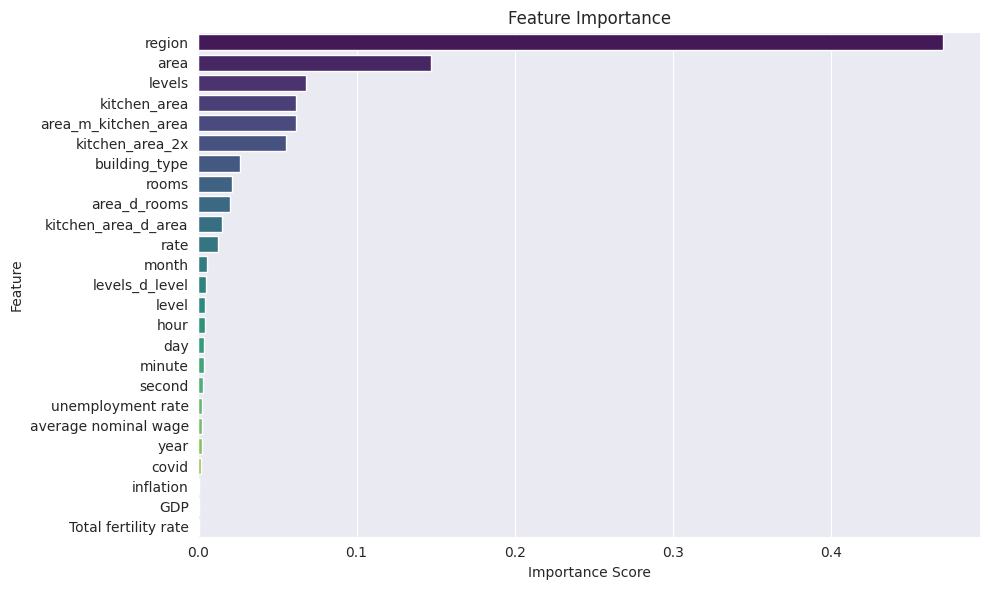

In [ ]:
feature_importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## LGBMRegressor

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    num_leaves = trial.suggest_int('num_leaves', 5, 100)
    min_child_samples = trial.suggest_int('min_child_samples', 20, 50)
    subsample = trial.suggest_float('subsample', 0.2, 1.0)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    test_rf_pred = model.predict(X_test)
    rmse_test_rf = root_mean_squared_error(y_test, test_rf_pred)


    return rmse_test_rf

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2025-05-29 16:00:03,193] A new study created in memory with name: no-name-a5cb833b-a616-4a85-a0e8-f399a4dd0e63
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:00:57,383] Trial 0 finished with value: 1114899.7178734958 and parameters: {'n_estimators': 355, 'max_depth': 8, 'learning_rate': 0.02960346989895244, 'num_leaves': 19, 'min_child_samples': 39, 'subsample': 0.6848856225765141}. Best is trial 0 with value: 1114899.7178734958.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:01:53,943] Trial 1 finished with value: 1011047.8051676264 and parameters: {'n_estimators': 232, 'max_depth': 42, 'learning_rate': 0.028246688826338982, 'num_leaves': 98, 'min_child_samples': 36, 'subsample': 0.24977261593850442}. Best is trial 1 with value: 1011047.8051676264.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:02:28,346] Trial 2 finished with value: 999392.8795313193 and parameters: {'n_estimators': 174, 'max_depth': 26, 'learning_rate': 0.0660692794993288, 'num_leaves': 69, 'min_child_samples': 43, 'subsample': 0.21299884152277235}. Best is trial 2 with value: 999392.8795313193.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:03:39,654] Trial 3 finished with value: 1032080.3922244409 and parameters: {'n_estimators': 325, 'max_depth': 34, 'learning_rate': 0.021203701973520256, 'num_leaves': 71, 'min_child_samples': 47, 'subsample': 0.32596480003883566}. Best is trial 2 with value: 999392.8795313193.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:04:32,798] Trial 4 finished with value: 1030518.0435551731 and parameters: {'n_estimators': 488, 'max_depth': 16, 'learning_rate': 0.0949231696693147, 'num_leaves': 15, 'min_child_samples': 31, 'subsample': 0.5564173786687092}. Best is trial 2 with value: 999392.8795313193.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:05:23,667] Trial 5 finished with value: 986709.7136526459 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.0982634411768597, 'num_leaves': 39, 'min_child_samples': 39, 'subsample': 0.9093531170625637}. Best is trial 5 with value: 986709.7136526459.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:06:17,239] Trial 6 finished with value: 1026718.836115636 and parameters: {'n_estimators': 492, 'max_depth': 26, 'learning_rate': 0.08793867971310657, 'num_leaves': 17, 'min_child_samples': 27, 'subsample': 0.8844890586384784}. Best is trial 5 with value: 986709.7136526459.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.518531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:07:10,248] Trial 7 finished with value: 1146487.5093093177 and parameters: {'n_estimators': 440, 'max_depth': 16, 'learning_rate': 0.06943008724057478, 'num_leaves': 6, 'min_child_samples': 42, 'subsample': 0.5324899203369271}. Best is trial 5 with value: 986709.7136526459.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:07:39,399] Trial 8 finished with value: 1180501.662262307 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.02471477845261739, 'num_leaves': 37, 'min_child_samples': 22, 'subsample': 0.3957742483507404}. Best is trial 5 with value: 986709.7136526459.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2138
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-29 16:08:22,808] Trial 9 finished with value: 1085942.590182405 and parameters: {'n_estimators': 222, 'max_depth': 9, 'learning_rate': 0.03220014661009963, 'num_leaves': 38, 'min_child_samples': 32, 'subsample': 0.8357390714663324}. Best is trial 5 with value: 986709.7136526459.


In [ ]:
print("Лучшие параметры:", study.best_params)
print("Лучшее значение метрики:", study.best_value)

Лучшие параметры: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.0982634411768597, 'num_leaves': 39, 'min_child_samples': 39, 'subsample': 0.9093531170625637}
Лучшее значение метрики: 986709.7136526459


In [ ]:
%%time
lg = LGBMRegressor(n_estimators= 300,
                   max_depth = 13,
                   learning_rate = 0.0982634411768597,
                   num_leaves = 39,
                   min_child_samples = 39,
                   subsample = 0.9093531170625637,
                   force_row_wise=True)
lg.fit(X_train, y_train)

train_lg_pred = lg.predict(X_train)
test_lg_pred = lg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3936264.663682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 1min 13s, sys: 288 ms, total: 1min 13s
Wall time: 1min 41s


In [ ]:
RMSE_train_lgmr = root_mean_squared_error(y_train, train_lg_pred)
RMSE_test_lgmr = mean_absolute_error(y_test, test_lg_pred)

r2_train_lgmr = r2_score(y_train, train_lg_pred)
r2_test_lgmr = r2_score(y_test, test_lg_pred)

mape_train_lgmr = mean_absolute_percentage_error(y_train, train_lg_pred)
mape_test_lgmr = mean_absolute_percentage_error(y_test, test_lg_pred)


print("RMSE train: ", round(RMSE_train_lgmr, 2))
print("RMSE test: ", round(RMSE_test_lgmr, 2))
print("r2 train: ", round(r2_train_lgmr, 2))
print("r2 test: ", round(r2_test_lgmr, 2))
print("mape train: ", round(mape_train_lgmr, 2))
print("mape test: ", round(mape_test_lgmr, 2))

RMSE train:  974625.77
RMSE test:  578620.27
r2 train:  0.91
r2 test:  0.9
mape train:  4.1
mape test:  19.15


In [ ]:
scores = cross_val_score(lg,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 24
[LightGBM] [Info] Start training from score 4090809.731896


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 4140782.470607


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 4091227.221503


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 1140391, number of used features: 25
[LightGBM] [Info] Start training from score 3751778.737789


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 1140392, number of used features: 25
[LightGBM] [Info] Start training from score 3614272.422946


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1086646.25


## XGBRegressor

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 250, 50),
        'seed': 0
    }

In [ ]:
def objective(space):
    xgbrb = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        random_state=space['seed'],
        tree_method='gpu_hist',
        device='cuda',
        n_jobs=-1
    )

    xgbrb.fit(X_train, y_train)
    test_xgbrb_pred = xgbrb.predict(X_test)
    rmse_test_xgbrb = root_mean_squared_error(y_test, test_xgbrb_pred)


    return rmse_test_xgbrb

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 10%|█         | 1/10 [00:08<01:16,  8.46s/trial, best loss: 847065.5573511285]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 20%|██        | 2/10 [00:17<01:11,  8.95s/trial, best loss: 847065.5573511285]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, Use

 30%|███       | 3/10 [00:32<01:22, 11.72s/trial, best loss: 802583.283950747] 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 40%|████      | 4/10 [00:52<01:28, 14.77s/trial, best loss: 799818.0661914964]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 50%|█████     | 5/10 [01:54<02:39, 31.92s/trial, best loss: 799818.0661914964]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 60%|██████    | 6/10 [01:59<01:30, 22.63s/trial, best loss: 799818.0661914964]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 70%|███████   | 7/10 [02:31<01:17, 25.88s/trial, best loss: 780509.4172499429]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:59:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 80%|████████  | 8/10 [03:13<01:01, 30.88s/trial, best loss: 778745.4515284174]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 9/10 [03:19<00:23, 23.09s/trial, best loss: 778745.4515284174]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



100%|██████████| 10/10 [03:23<00:00, 20.35s/trial, best loss: 778745.4515284174]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:00:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



In [ ]:
best_hyperparams

{'colsample_bytree': np.float64(0.9327646447389925),
 'gamma': np.float64(3.6791855492970056),
 'max_depth': np.float64(15.0),
 'min_child_weight': np.float64(0.0),
 'n_estimators': np.float64(200.0),
 'reg_alpha': np.float64(123.0),
 'reg_lambda': np.float64(0.8777028577406624)}

In [ ]:
%%time
xgbr = XGBRegressor(colsample_bytree = 0.9327646447389925,
                    gamma = 3.6791855492970056,
                    max_depth = 15,
                    min_child_weight = 0,
                    n_estimators = 200,
                    reg_alpha = 123,
                    reg_lambda = 0.8777028577406624,
                    tree_method='gpu_hist',
                    device='cuda',
                    n_jobs=-1
                    )
xgbr.fit(X_train, y_train)
train_xgbr_pred = xgbr.predict(X_train)
test_xgbr_pred = xgbr.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:01:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


CPU times: user 46.6 s, sys: 894 ms, total: 47.5 s
Wall time: 53.5 s


In [ ]:
RMSE_train_base = root_mean_squared_error(y_train, train_xgbr_pred)
RMSE_test_base = mean_absolute_error(y_test, test_xgbr_pred)

r2_train_base = r2_score(y_train, train_xgbr_pred)
r2_test_base = r2_score(y_test, test_xgbr_pred)

mape_train_base = mean_absolute_percentage_error(y_train, train_xgbr_pred)
mape_test_base = mean_absolute_percentage_error(y_test, test_xgbr_pred)


print("RMSE train: ", round(RMSE_train_base, 2))
print("RMSE test: ", round(RMSE_test_base, 2))
print("r2 train: ", round(r2_train_base, 2))
print("r2 test: ", round(r2_test_base, 2))
print("mape train: ", round(mape_train_base, 2))
print("mape test: ", round(mape_test_base, 2))

RMSE train:  96253.2
RMSE test:  387199.34
r2 train:  1.0
r2 test:  0.94
mape train:  0.16
mape test:  15.6


In [ ]:
scores = cross_val_score(xgbr,  X_scaled, y, cv=5, scoring='neg_root_mean_squared_error').mean()
print(-round(scores, 2))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

1048393.42
